### AGN metrics

The AGN-specific metrics include 
 * a metric to calculate the number of QSO expected per sq degree (NQSO metric)
 * a metric to calculate the expected errors on the SF (AGN SFUncert metric)
 * a metric to calculate how well sampled various time lags will be (AGN TimeLags metric)
 
Demonstration notebooks for each of these metrics can be found in the [`rubin_sim_notebooks` repo](https://github.com/lsst/rubin_sim_notebooks/tree/main/maf/science), in the `maf/science` directory. 

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import colorcet
import IPython

import rubin_sim.maf as maf

Here, we will look at some of the summary metrics calculated for these AGN metrics. 
While there are more summary metrics available, the subset pulled out are these:

In [6]:
metric_set = maf.get_metric_sets()
agn_sets = [m for m in metric_set.groupby('metric set').first().index if 'AGN' in m]
agn_sets

['AGN N QSO', 'AGN SF', 'AGN timelag']

In [7]:
families = maf.get_family_descriptions()
summaries = maf.get_metric_summaries()

We can look at all of the metric outputs for all runs, but the result is hard to follow. So we'll look at the overall picture of things to identify interesting families of simulations (i.e. where the survey strategy impacts the metric results) and then look at those families in more detail. More information on the overall survey strategy variations and how these are implemented in various families is available in the [summary info](https://github.com/lsst-pst/survey_strategy/blob/main/fbs_2.0/SummaryInfo_v2.1.ipynb) notebook.

In [8]:
family_list = families.index.to_list()
family_list

['baseline',
 'rolling',
 'triplets',
 'long gaps no pairs',
 'bluer balance',
 'longer u visits',
 'vary nes',
 'vary gp',
 'galactic plane footprint',
 'vary expt',
 'good seeing',
 'microsurveys',
 'technical',
 'suppress repeats',
 'ddf percent',
 'ddf euclid moved',
 'ddf season length',
 'ddf double',
 'ddf quad',
 'ddf quad subfilter',
 'ddf bright',
 'ddf dither',
 'ddf roll',
 'ddf accordian',
 'ddf old rot',
 'ddf deep universal',
 'ddf deep rolling',
 'ddf early deep']

In [9]:
def plot_lines(families, family_list):
    lines = []
    for f in family_list:
        lines += [len(families.loc[f]['run'])]
    lines = np.array(lines).cumsum()
    return lines

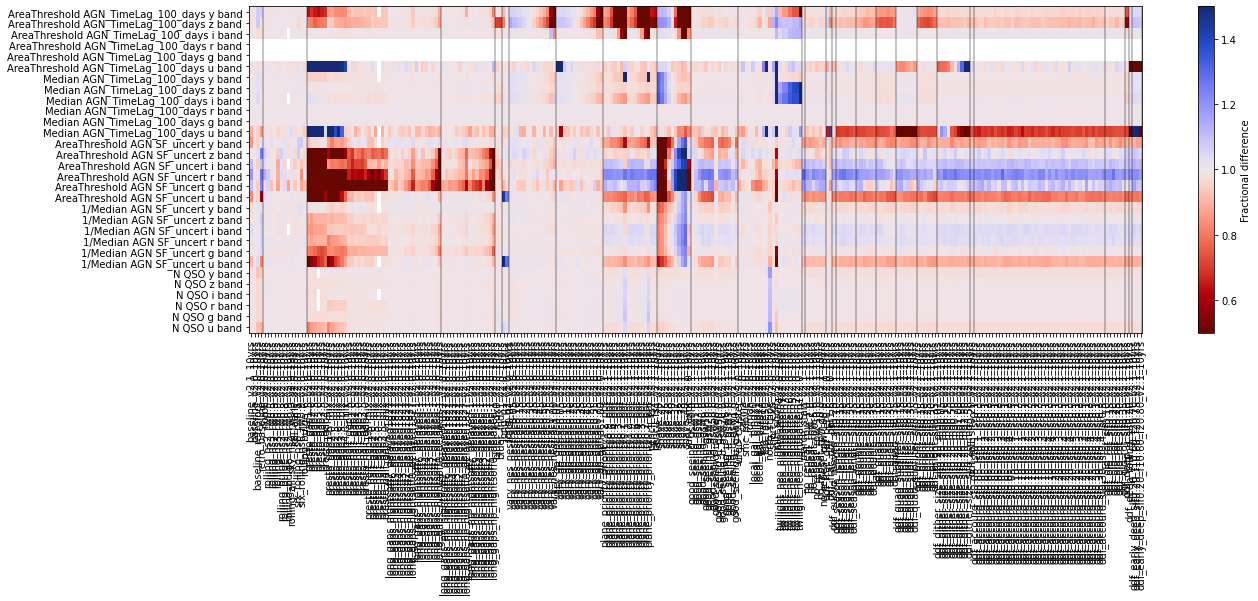

In [10]:
# All AGN metrics over all runs
these_runs = families.explode(['run']).loc[:]['run']
metrics = metric_set.loc[agn_sets].reset_index('metric set')
baseline = 'baseline_v2.0_10yrs'

fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metrics['metric']],
                                  baseline_run=baseline,
                                  metric_label_map=metrics['short_name'],
                                  metric_set=metrics)
fig.set_figwidth(20)
for l in plot_lines(families, family_list):
    ax.axvline(l, color='k', alpha=0.3)

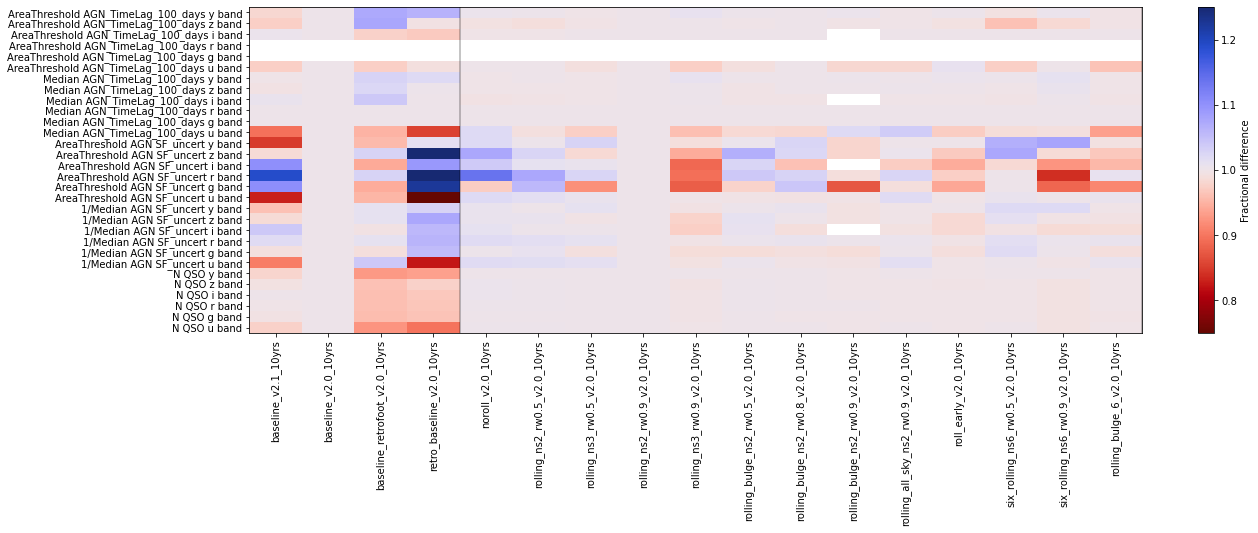

In [11]:
# All AGN metrics, a subset of runs which focus on seasonal-length cadence
fams = ['baseline', 'rolling']
these_runs = families.explode(['run']).loc[fams]['run']
baseline = families.loc['rolling']['reference']
fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metrics['metric']],
                                  baseline_run=baseline,
                                  metric_label_map=metrics['short_name'],
                                  metric_set=metrics, 
                                  color_range=0.5)
fig.set_figwidth(20)
for l in plot_lines(families, fams):
    ax.axvline(l, color='k', alpha=0.3)

This looks like the change in the footprint from v1.X to v2.0 (the 'retro' runs to the baseline_v2.0_10yrs) is generally an improvement, although may slightly increase SF uncertainty. The median individual image depth in v2.1 is slightly shallower in u and y bands, while deeper in r and i bands, but it's relatively minor (this is the result of prioritizing good seeing images in r and i bands in v2.1). 

The addition of rolling cadence is relatively neutral (see the 'noroll' run), as is the impact of rolling cadence in general. Strong rolling cadence in a larger number of bands (like "ns3" or "six" runs) gives slightly negative results, but nothing super significant.

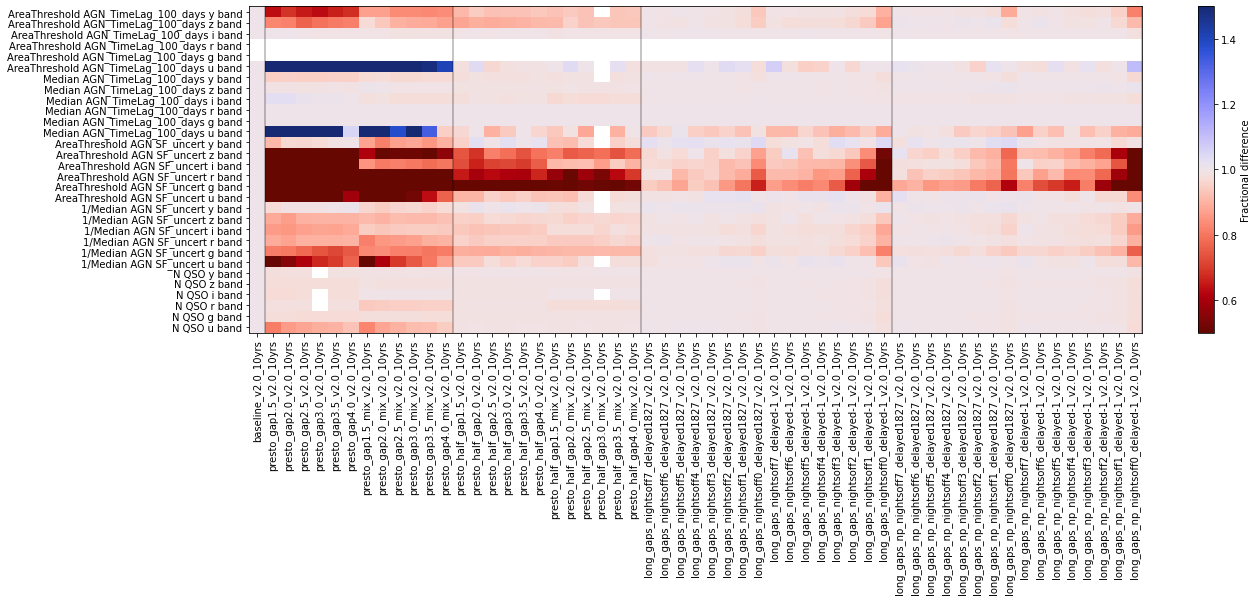

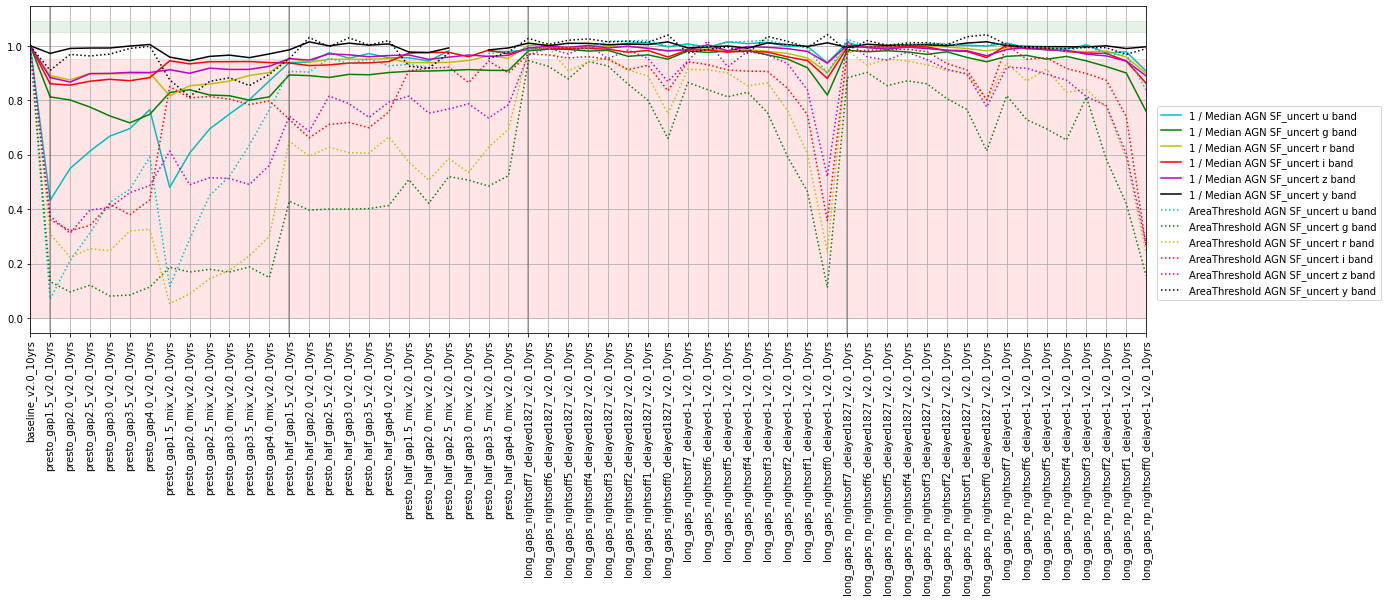

In [12]:
# all AGN metrics, intra-night cadence 
fams = ['triplets', 'long gaps no pairs']
baseline = 'baseline_v2.0_10yrs'
these_runs = np.concatenate([[baseline], families.explode(['run']).loc[fams]['run']])

lines = [1,]
runs = list(these_runs)
lines += [len([r for r in runs if r.startswith('presto_gap')])]
lines += [len([r for r in runs if r.startswith('presto_half')])]
lines += [len([r for r in runs if r.startswith('long_gaps_nights')])]
lines += [len([r for r in runs if r.startswith('long_gaps_np')])]
lines = np.array(lines).cumsum()

fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metrics['metric']],
                                  baseline_run=baseline,
                                  metric_label_map=metrics['short_name'],
                                  metric_set=metrics)
fig.set_figwidth(20)
for l in lines:
    ax.axvline(l, color='k', alpha=0.3)

fig, ax = maf.plot_run_metric(summaries.loc[these_runs, metric_set.loc['AGN SF']['metric']],
                                  baseline_run=baseline,
                                  metric_label_map=metric_set.loc['AGN SF']['short_name'],
                                  metric_set=metric_set.loc['AGN SF'],
                             horizontal_quantity='run',
                             vertical_quantity='value')
fig.set_figwidth(20)
ax.legend(loc=(1.01, 0.1))
for l in lines:
    ax.axvline(l, color='k', alpha=0.3)

The 'presto' series shows negative impacts to AGN SF uncertainty metrics, primarily in the amount of area that reaches the threshold value of SF uncertainty = 0.04. This is linked to how often a triplet rather than just a pair of visits occurs in each night. None of these families attempts to take triplets for all images -- typically the first or first few "blobs" of pairs will get a triplet, if the interval is short. The 'presto_gap' family takes triplets at a variety of intervals every night; the 'presto_half' takes triplets every other night. The 'long gaps' takes triplets for the first blob of the night every 'nightsoff' - as these become more common (e.g. nightsoff1) the median SF uncertainty is largely unchanged but the amount of area that reaches the threshold value drops. The 'long gaps no pairs' family does NOT take triplets, but does separate the first pair of visits in the 'active' nights by 2-7 hours instead of 33 minutes.  

So, this is perhaps a bit complicated. The threshold value for the "Area" is right at the median value for the baseline survey -- perhaps a poor choice, in retrospect. Simulations where the uncertainty dips slightly above this value will result in quick drops of area below this threshold, as large regions will start to fail the criteria. 
We see a similar effect in "fO Area" -- the area that receives at least X visits per pointing, when we set the threshold to 825 visits per pointing. And if we set the threshold to 750 visits per pointing, then we see very stable results. 
As a result, "Area" kinds of metrics are useful, but can be volatile when the threshold is close to the expected value. 
Most likely, we should focus more on the median SF uncertainty, and consider the area (and perhaps recalculate an area with a lower threshold value in addition to this one). 

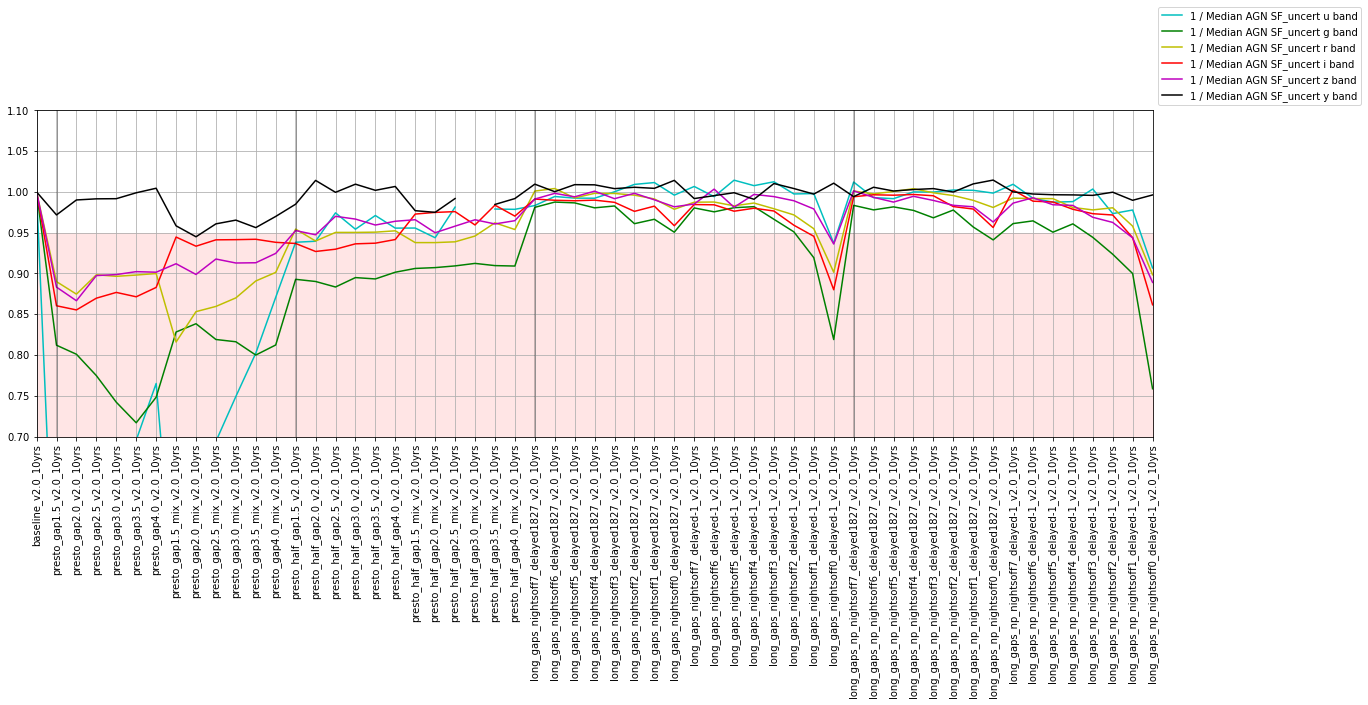

In [13]:
msubset = metric_set.loc['AGN SF'].query('invert == True')
fig, ax = maf.plot_run_metric(summaries.loc[these_runs, msubset['metric']],
                                  baseline_run='baseline_v2.0_10yrs',
                                  metric_label_map=msubset['short_name'],
                                  metric_set=msubset,
                             horizontal_quantity='run',
                             vertical_quantity='value')
fig.set_figwidth(20)
ax.set_ylim(0.7, 1.1)
for l in lines:
    ax.axvline(l, color='k', alpha=0.3)

And here we see that the long_gaps family is fairly neutral (except `long_gaps_nightsoff0_delayed-1`, the case where triplets are attempted every night for the entire survey, not delayed by 5 years), and is similarly bad for `long_gaps_np_nightsoff0_delayed-1`

baseline_v2.1_10yrs


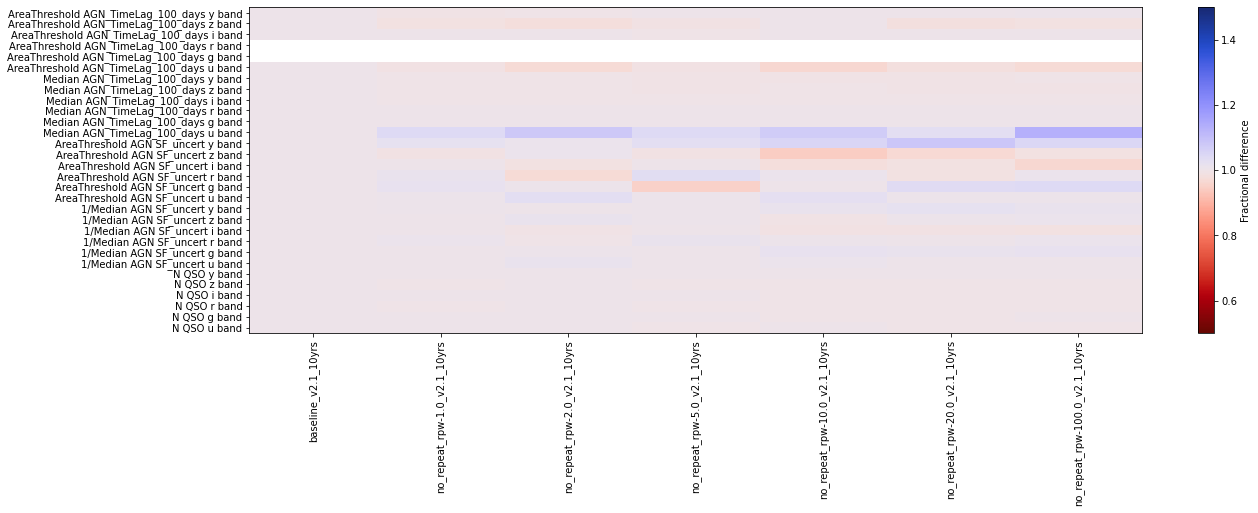

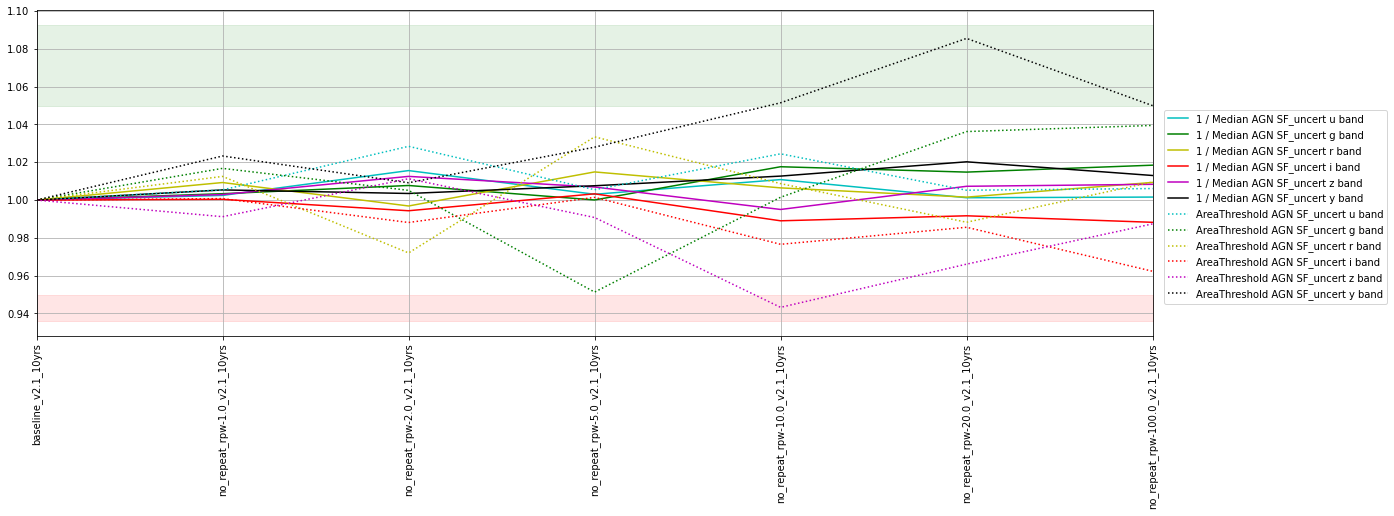

In [14]:
# AGN metrics, suppress repeats - number of nights with visits
fams = ['suppress repeats']
baseline = families.loc[fams]['reference'][0]
print(baseline)
these_runs = np.concatenate([[baseline], families.explode(['run']).loc[fams]['run']])

fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metrics['metric']],
                                  baseline_run=baseline,
                                  metric_label_map=metrics['short_name'],
                                  metric_set=metrics)
fig.set_figwidth(20)


fig, ax = maf.plot_run_metric(summaries.loc[these_runs, metric_set.loc['AGN SF']['metric']],
                                  baseline_run=baseline,
                                  metric_label_map=metric_set.loc['AGN SF']['short_name'],
                                  metric_set=metric_set.loc['AGN SF'],
                             horizontal_quantity='run',
                             vertical_quantity='value')
fig.set_figwidth(20)
ax.legend(loc=(1.01, 0.1))

The suppress repeats family adds a weight to remove repetition of pointings within a given night (pairs are acquired, but this reduces the likelihood of additional visits in the same night). This change appears to introduce some scatter in the median SF uncertainty but, without a preference for a given bandpass, is generally neutral. 

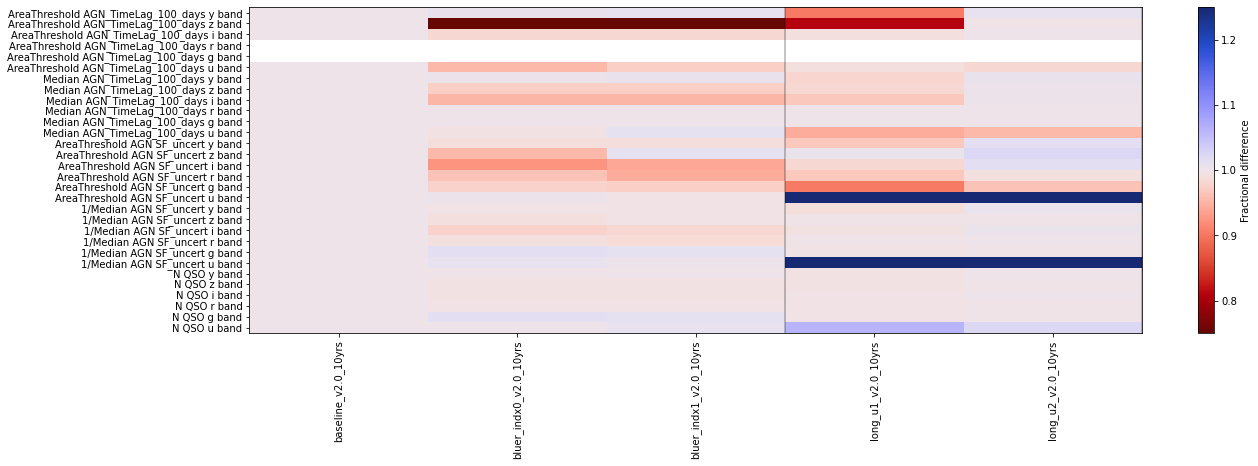

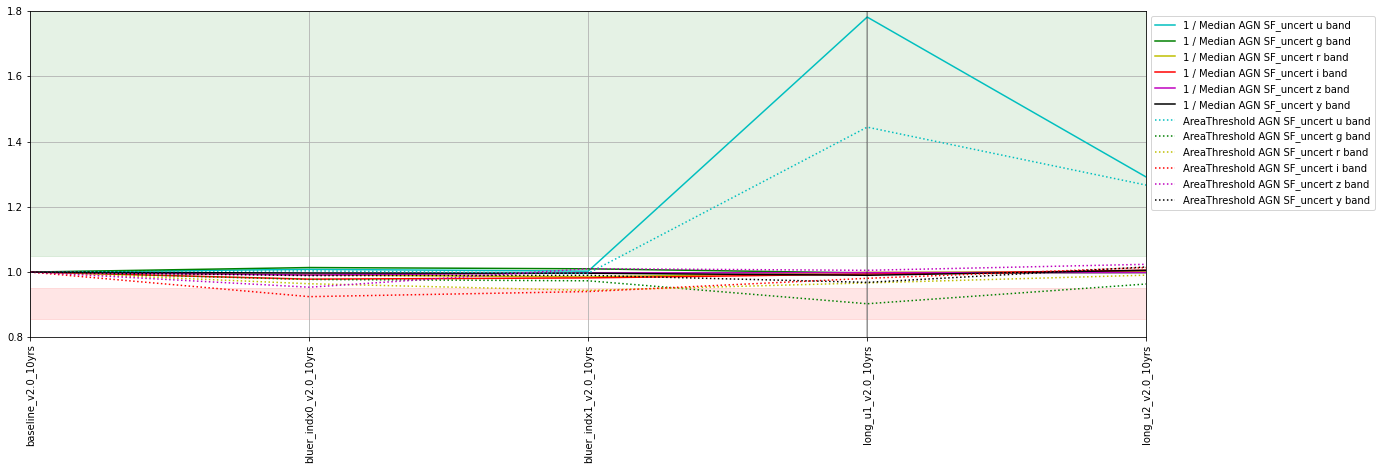

In [15]:
# Other families
fams = ['bluer balance', 'longer u visits']

baseline = families.loc[fams]['reference'][0]
these_runs = np.concatenate([[baseline], families.explode(['run']).loc[fams]['run']])

fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metrics['metric']],
                                  baseline_run=baseline,
                                  metric_label_map=metrics['short_name'],
                                  metric_set=metrics, 
                                  color_range=0.5)
fig.set_figwidth(20)
for l in (plot_lines(families, fams)+1):
    ax.axvline(l, color='k', alpha=0.3)
    
msubset = metric_set.loc['AGN SF']#.query('invert == True')
fig, ax = maf.plot_run_metric(summaries.loc[these_runs, msubset['metric']],
                                  baseline_run=baseline,
                                  metric_label_map=msubset['short_name'],
                                  metric_set=msubset,
                             horizontal_quantity='run',
                             vertical_quantity='value')
fig.set_figwidth(20)
ax.set_ylim(0.8, 1.8)
for l in (plot_lines(families, fams)+1):
    ax.axvline(l, color='k', alpha=0.3)

Changing the filter balance to skew towards more u or g visits is a neutral effect. However, adding longer u band visits is very beneficial for the AGN structure function uncertainty in u band. This comes at a slight cost in the area covered to an uncertainty of 0.04. 

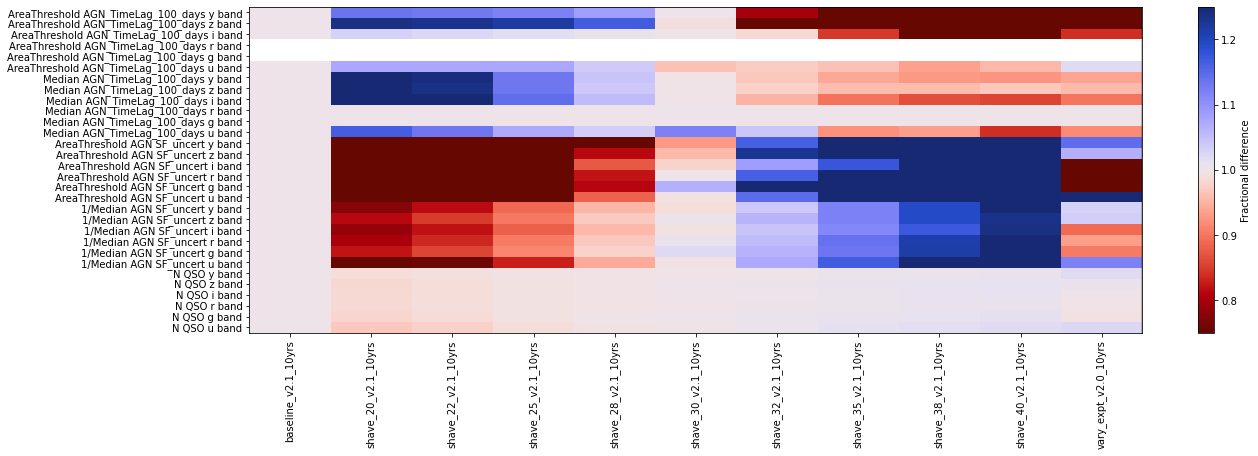

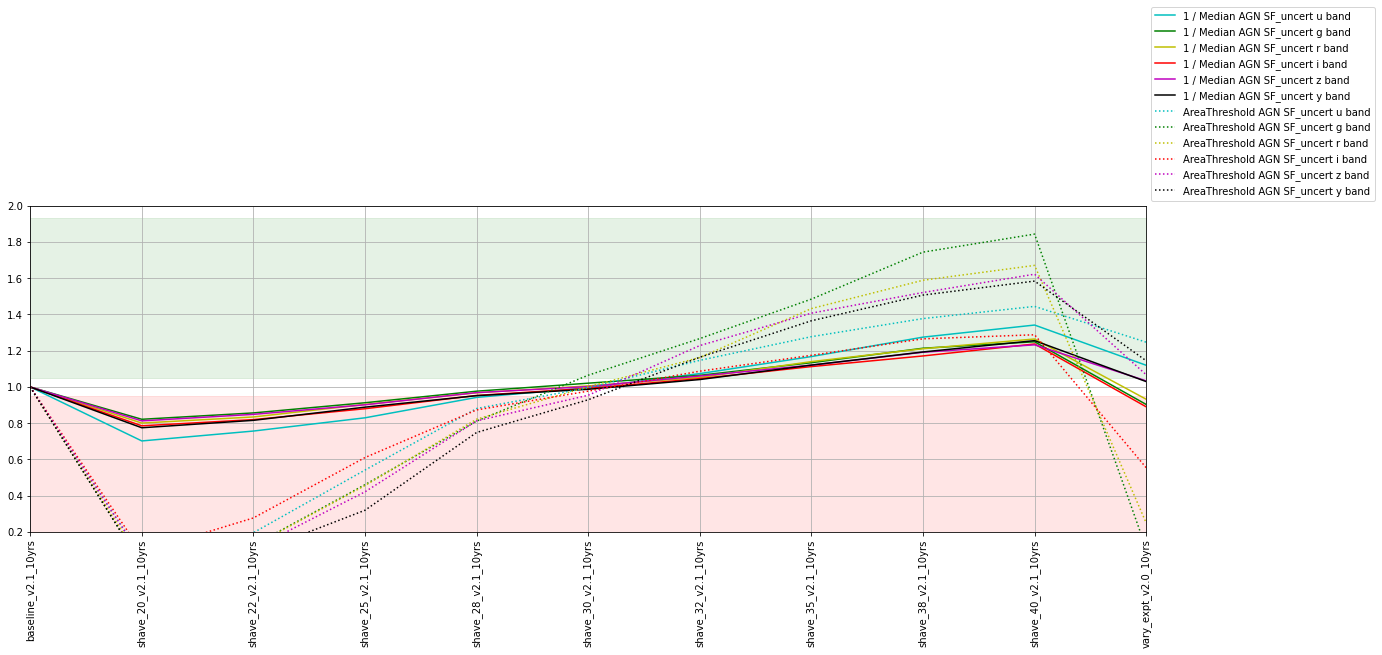

In [17]:
# Other families
fams = ['vary expt']

baseline = families.loc[fams]['reference'][0]
these_runs = np.concatenate([[baseline], families.explode(['run']).loc[fams]['run']])

fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metrics['metric']],
                                  baseline_run=baseline,
                                  metric_label_map=metrics['short_name'],
                                  metric_set=metrics, 
                                  color_range=0.5)
fig.set_figwidth(20)
for l in (plot_lines(families, fams)+1):
    ax.axvline(l, color='k', alpha=0.3)
    
msubset = metric_set.loc['AGN SF']#.query('invert == True')
fig, ax = maf.plot_run_metric(summaries.loc[these_runs, msubset['metric']],
                                  baseline_run=baseline,
                                  metric_label_map=msubset['short_name'],
                                  metric_set=msubset,
                             horizontal_quantity='run',
                             vertical_quantity='value')
fig.set_figwidth(20)
ax.set_ylim(0.2, 2)
for l in (plot_lines(families, fams)+1):
    ax.axvline(l, color='k', alpha=0.3)

Relatedly, changing the exposure time also drives the SF uncertainty - shorter visits result in larger uncertainties, longer visits result in smaller uncertainties. This is likely tied with the magnitude values used to evaluate the SF uncertainty -- these are constant across simulations, so the SNR in each typical image changes. 

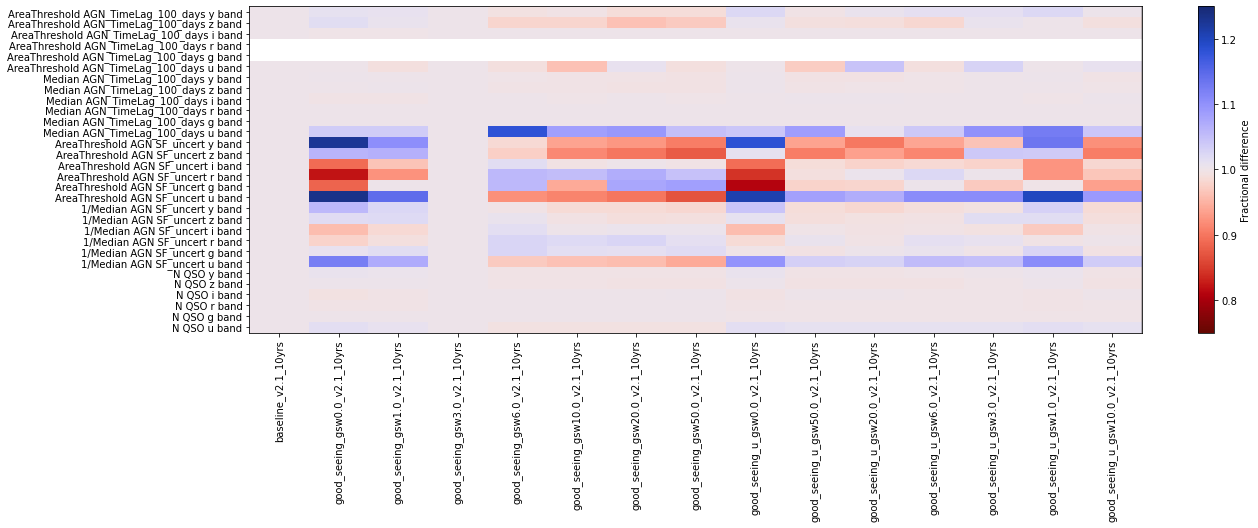

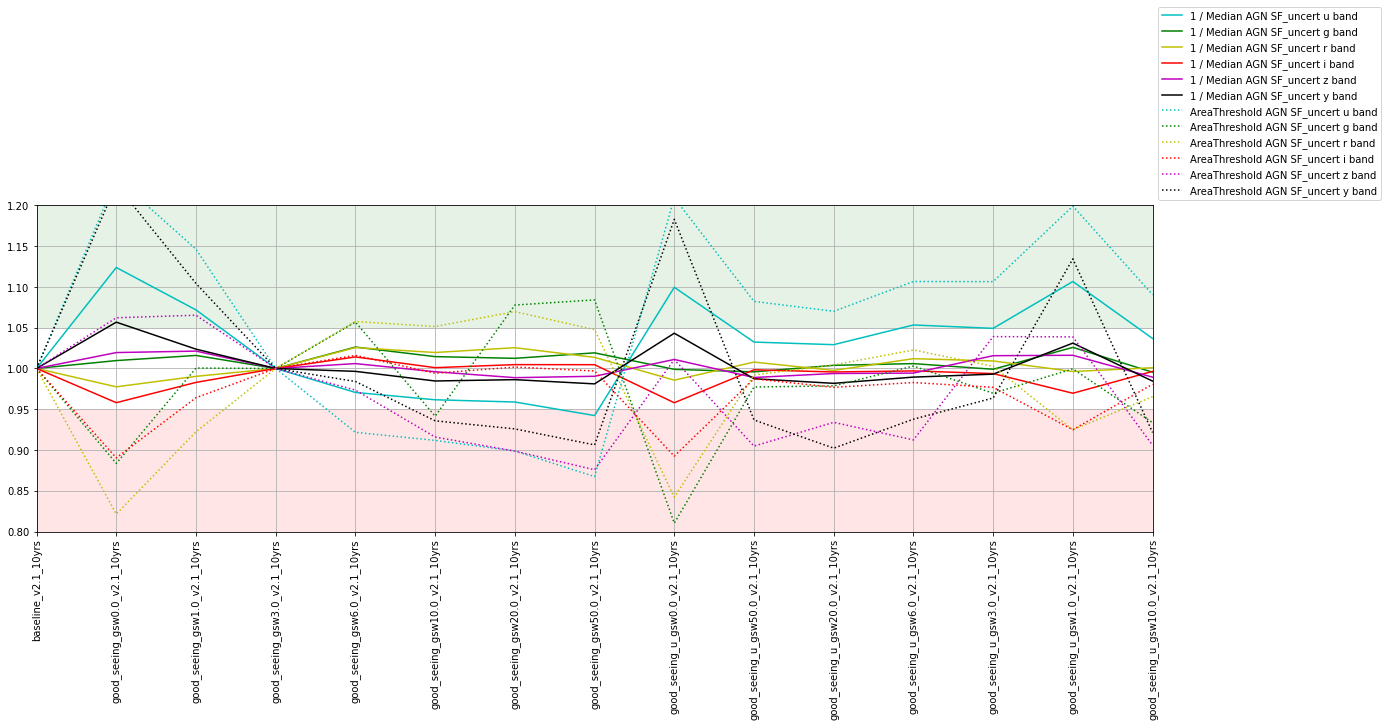

In [18]:
fams = ['good seeing', ]

baseline = families.loc[fams]['reference'][0]
these_runs = np.concatenate([[baseline], families.explode(['run']).loc[fams]['run']])

fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metrics['metric']],
                                  baseline_run=baseline,
                                  metric_label_map=metrics['short_name'],
                                  metric_set=metrics, 
                                  color_range=0.5)
fig.set_figwidth(20)
for l in (plot_lines(families, fams)+1):
    ax.axvline(l, color='k', alpha=0.3)
    
msubset = metric_set.loc['AGN SF']#.query('invert == True')
fig, ax = maf.plot_run_metric(summaries.loc[these_runs, msubset['metric']],
                                  baseline_run=baseline,
                                  metric_label_map=msubset['short_name'],
                                  metric_set=msubset,
                             horizontal_quantity='run',
                             vertical_quantity='value')
fig.set_figwidth(20)
ax.set_ylim(0.8, 1.2)
for l in (plot_lines(families, fams)+1):
    ax.axvline(l, color='k', alpha=0.3)

Choosing to acquire 'good seeing' images in various bandpasses changes the SF uncertainty estimates as well, but generally in terms of increasing the scatter. The decreases in uncertainty in some bandpasses are countered with increases in other bands, as basically this represents trading "good seeing" time between bandpasses in the scheduler. 

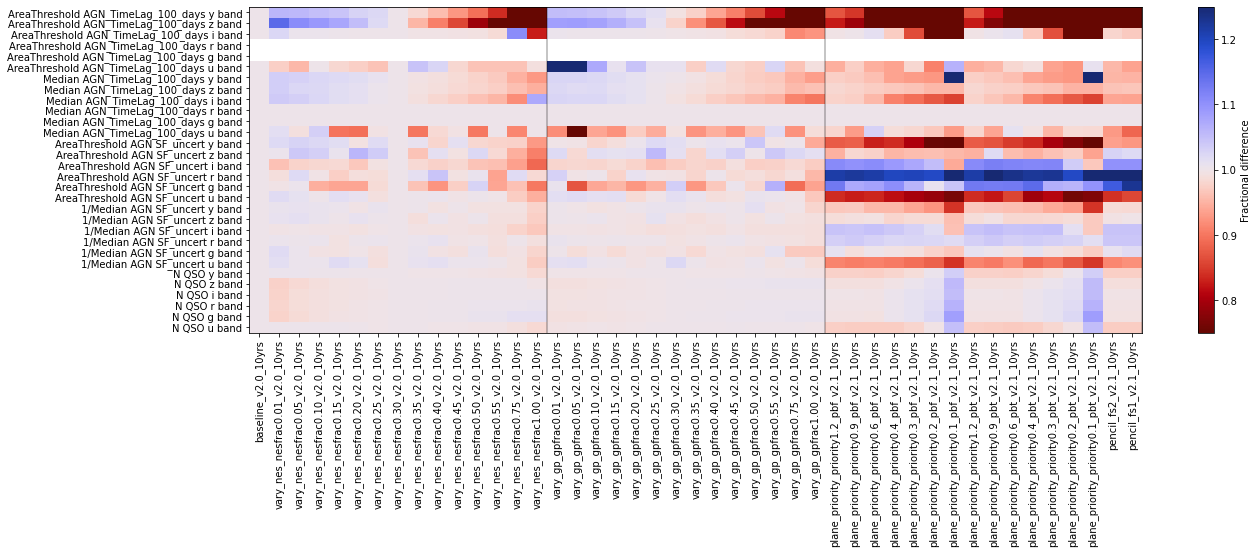

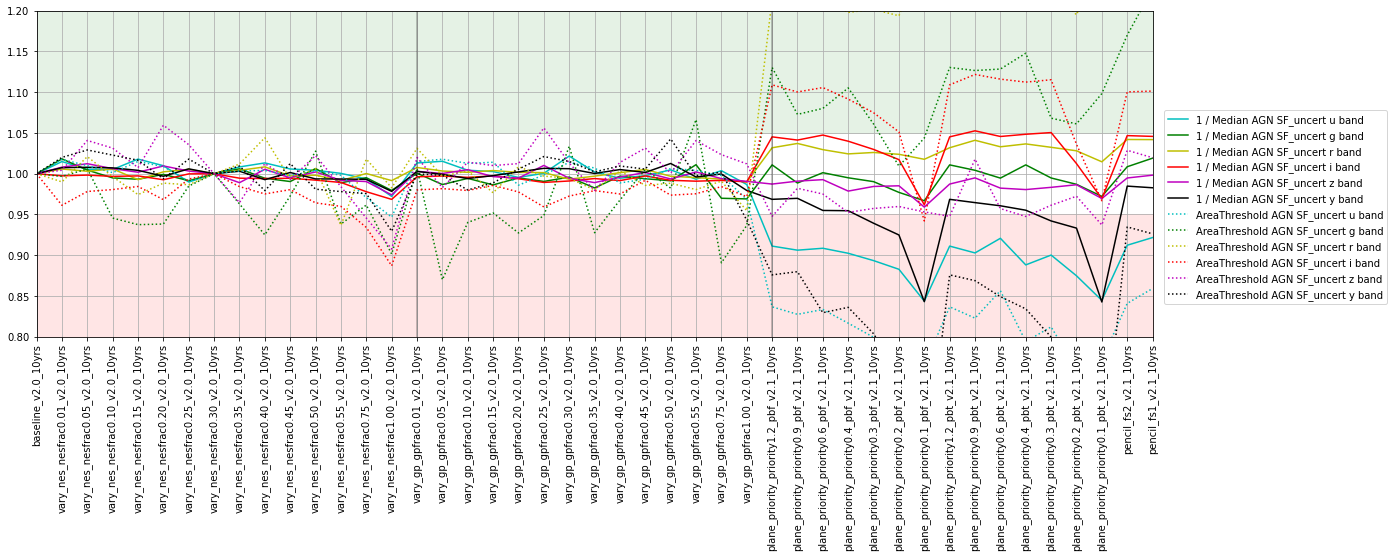

In [19]:
# Footprint options

fams = ['vary nes', 'vary gp', 'galactic plane footprint']

baseline = families.loc[fams]['reference'][0]
these_runs = np.concatenate([[baseline], families.explode(['run']).loc[fams]['run']])

fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metrics['metric']],
                                  baseline_run=baseline,
                                  metric_label_map=metrics['short_name'],
                                  metric_set=metrics, 
                                  color_range=0.5)
fig.set_figwidth(20)
for l in (plot_lines(families, fams)+1):
    ax.axvline(l, color='k', alpha=0.3)
    
msubset = metric_set.loc['AGN SF']#.query('invert == True')
fig, ax = maf.plot_run_metric(summaries.loc[these_runs, msubset['metric']],
                                  baseline_run=baseline,
                                  metric_label_map=msubset['short_name'],
                                  metric_set=msubset,
                             horizontal_quantity='run',
                             vertical_quantity='value')
fig.set_figwidth(20)
ax.set_ylim(0.8, 1.2)
ax.legend(loc=(1.01, 0.1))
for l in (plot_lines(families, fams)+1):
    ax.axvline(l, color='k', alpha=0.3)

Basically each of these families represents spending slightly more (left side of each family) or less (right side) of survey time in these mini-survey regions, instead of in the WFD regions. While the vary_nes and vary_gp families are relatively small effects until they ramp up to "equivalent to WFD weight", the galactic plane footprint family shows a wider spread in effect - including both positive and negative impacts in different bandpasses. 
It is likely worth noting that the mini-survey regions are observed with a different filter distribution than the main low-dust WFD, which likely explains the different impacts in different filters. 

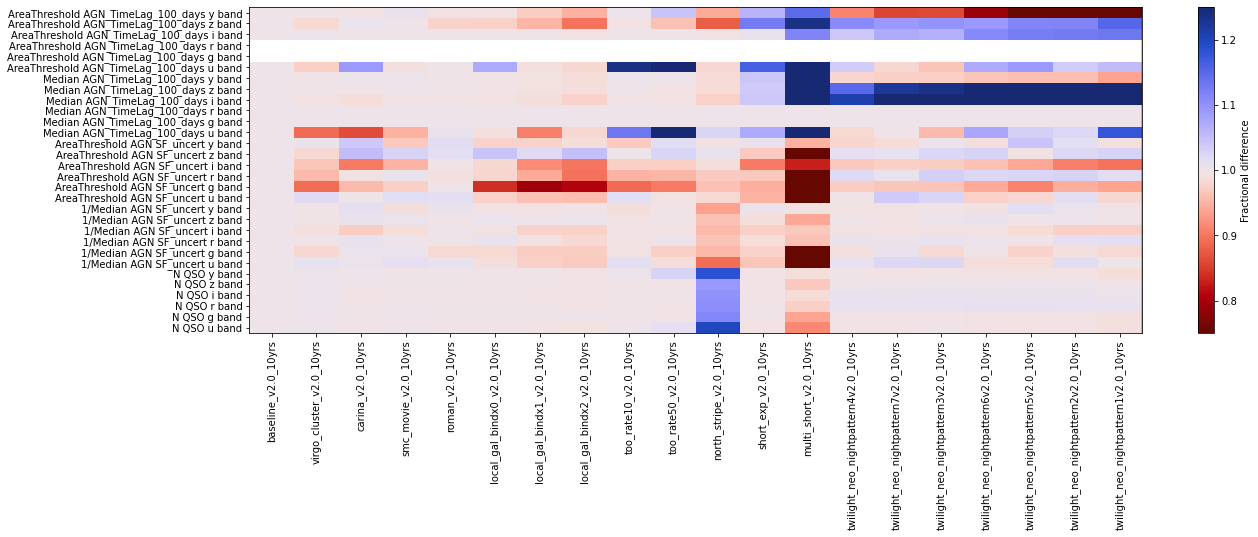

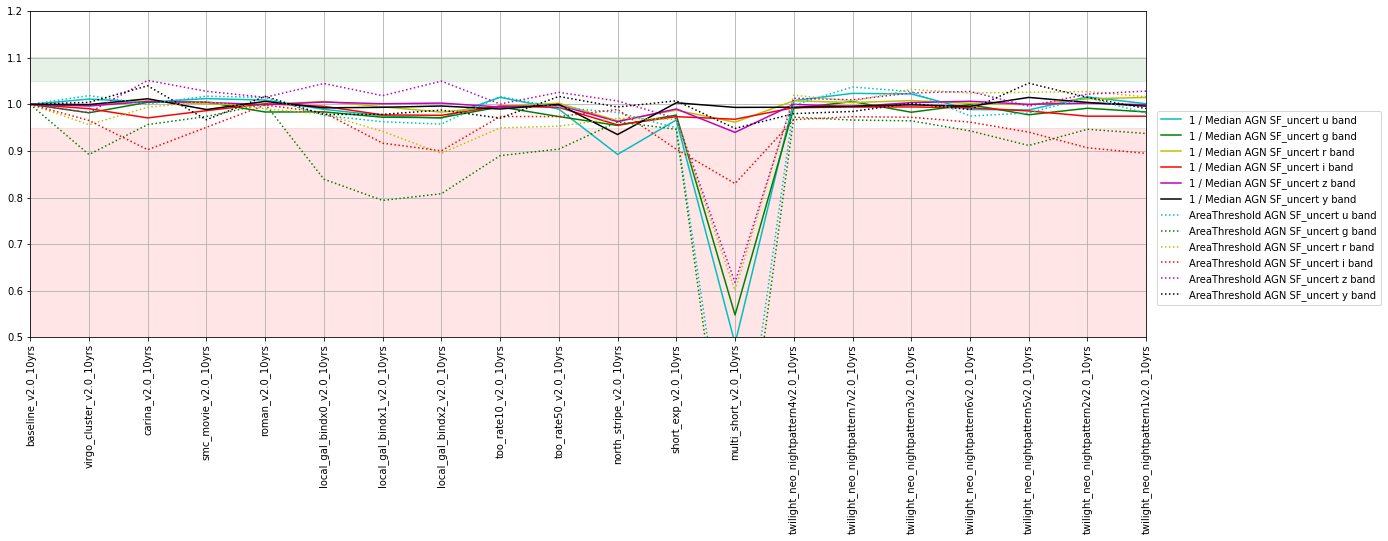

In [20]:
fams = ['microsurveys']
baseline = families.loc[fams]['reference'][0]
these_runs = np.concatenate([[baseline], families.explode(['run']).loc[fams]['run']])

fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metrics['metric']],
                                  baseline_run=baseline,
                                  metric_label_map=metrics['short_name'],
                                  metric_set=metrics, 
                                  color_range=0.5)
fig.set_figwidth(20)
for l in (plot_lines(families, fams)+1):
    ax.axvline(l, color='k', alpha=0.3)
    
msubset = metric_set.loc['AGN SF']#.query('invert == True')
fig, ax = maf.plot_run_metric(summaries.loc[these_runs, msubset['metric']],
                                  baseline_run=baseline,
                                  metric_label_map=msubset['short_name'],
                                  metric_set=msubset,
                             horizontal_quantity='run',
                             vertical_quantity='value')
fig.set_figwidth(20)
ax.set_ylim(0.5, 1.2)
ax.legend(loc=(1.01, 0.1))
for l in (plot_lines(families, fams)+1):
    ax.axvline(l, color='k', alpha=0.3)

None of these microsurveys are set up to benefit AGNs in particular, so it's not surprising there are no big boosts in the metrics here. The `multi_short` microsurvey drives many visits into short (low SNR) visits, which has a clear negative impact on the SF metric results. Most of the other microsurveys are relatively neutral. 

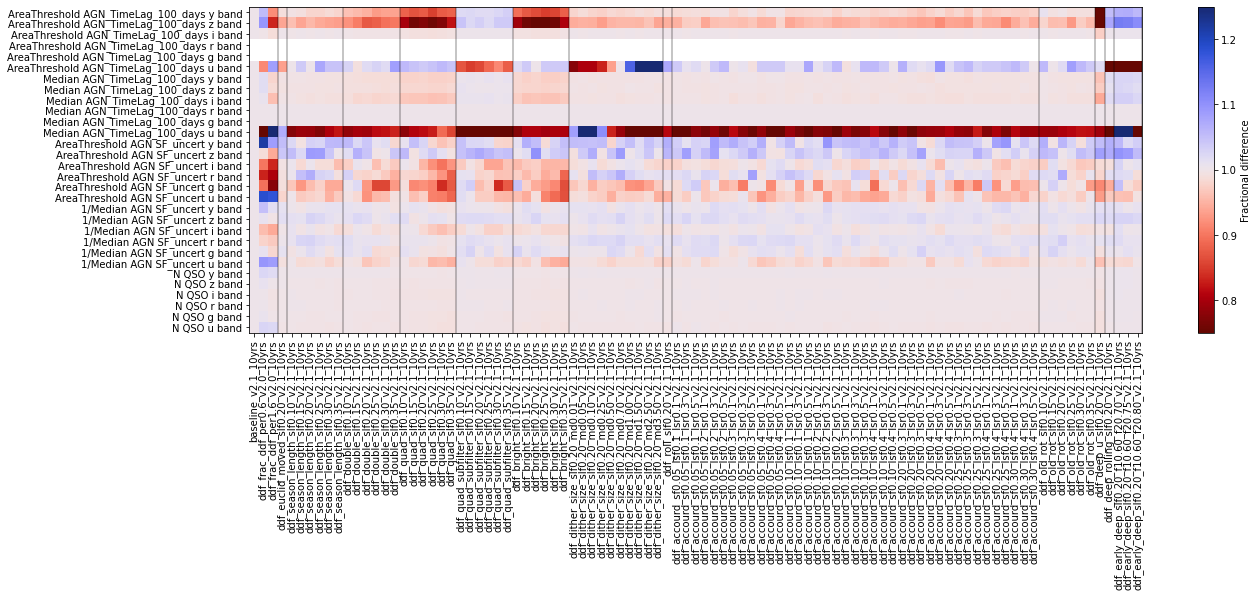

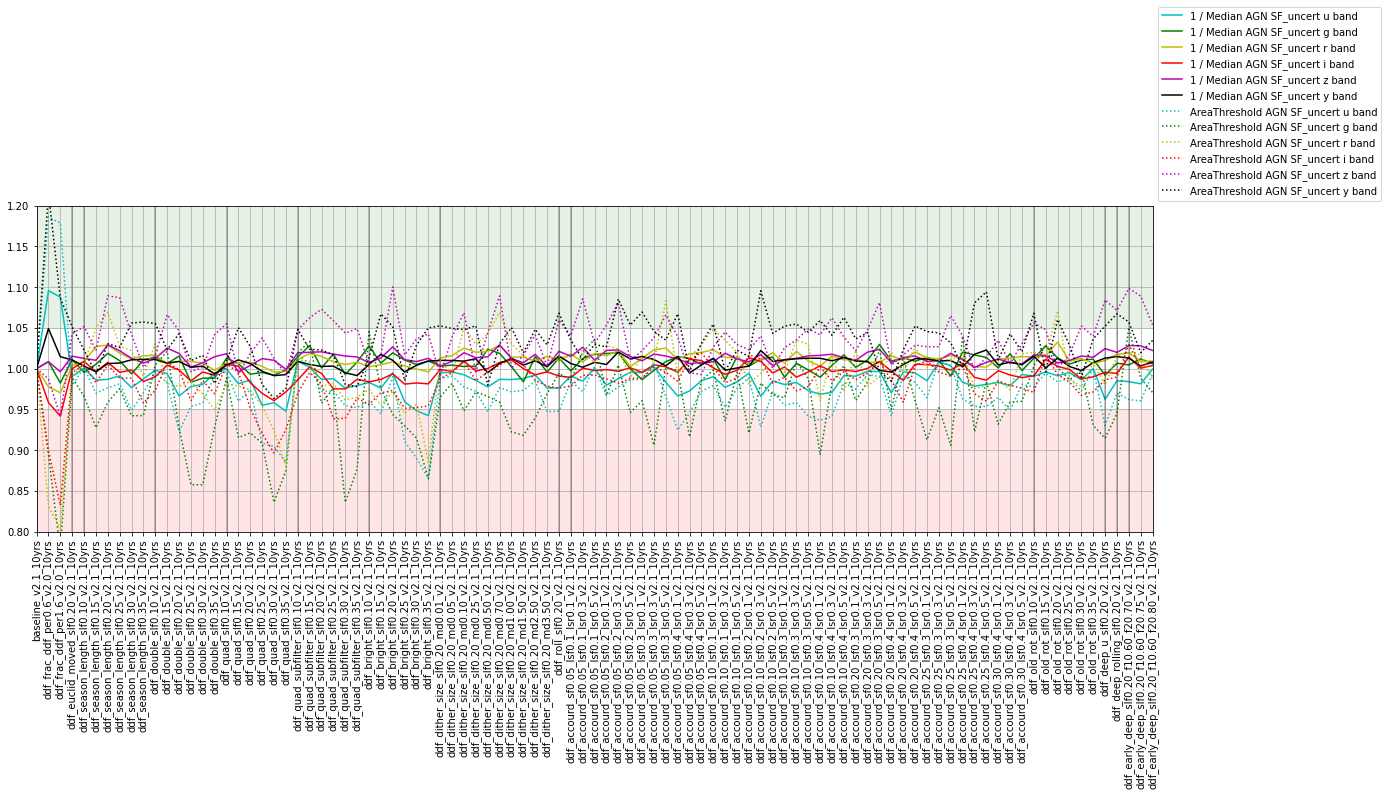

In [21]:
fams = [f for f in family_list if f.startswith('ddf')]

#baseline = families.loc[fams]['reference'][0]
baseline = 'baseline_v2.1_10yrs'
these_runs = np.concatenate([[baseline], families.explode(['run']).loc[fams]['run']])

fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metrics['metric']],
                                  baseline_run=baseline,
                                  metric_label_map=metrics['short_name'],
                                  metric_set=metrics, 
                                  color_range=0.5)
fig.set_figwidth(20)
for l in (plot_lines(families, fams)+1):
    ax.axvline(l, color='k', alpha=0.3)
    
msubset = metric_set.loc['AGN SF']#.query('invert == True')
fig, ax = maf.plot_run_metric(summaries.loc[these_runs, msubset['metric']],
                                  baseline_run=baseline,
                                  metric_label_map=msubset['short_name'],
                                  metric_set=msubset,
                             horizontal_quantity='run',
                             vertical_quantity='value')
fig.set_figwidth(20)
ax.set_ylim(0.8, 1.2)
for l in (plot_lines(families, fams)+1):
    ax.axvline(l, color='k', alpha=0.3)

So this is a bit complicated - v2.1 introduces pre-scheduled DDFs, so those runs are all a bit different from the 'original'. However, the metrics above reflect what is happening in the "rest of the sky" not the DDF fields. Generally, what I'd take away from these is that as the season length changes (`ddf_season_length` runs), things don't change too much, but as the sequences in the DDF get shorter (`ddf_double`, `ddf quad`, etc.) then statistics in the general WFD go down somewhat. Again, the area threshold metric may be overly sensitive to variations that may not lead to a lot of real changes in the science gained - and the median values of the SF uncertainty don't change much through the various DDF runs (beyond the ddf_frac versions, which vary the overall time). 

Basically what it seems like we see here is that more visits in the non-DD survey = better metrics in the non-DD survey, and at a proportionality lower than 1-1. 

But what is really interesting for these DDF runs, now we think that the impact in the 'rest of the survey' is minimal, is the metrics in the ddf fields themselves. 

In [24]:
# Pull out DDF specific AGN metrics
ddfs = ['ELAISS1', 'XMM-LSS', 'COSMOS', 'ECDFS', 'EDFS']
metrics = [f'Median AGN SF Uncert, {ddf} SFU, {ddf} {f} HealpixSubsetSlicer' for ddf in ddfs for f in 'ugrizy']
short_names = [f'Median AGN SF Uncert {ddf} {f}' for ddf in ddfs for f in 'ugrizy']
style = ['c-', 'g-', 'y-', 'r-', 'm-', 'k-']*5
invert = True
mset = maf.create_metric_set_df('AGN SF DDF', metrics, short_names, style, invert=invert)
#mset

In [34]:
maf.describe_families(families.loc[['ddf season length']])

---
**ddf season length** : This family investigates the effect of varying the season length within the DDF fields. `season length fraction` reflects how much of the available season is used -- 0.1 indicates that 10% of the available season is removed at each end (for a total of 80% of the available season used for observations), while 0.3 would indicate that 40% of the total possible season is used. This family uses pre-scheduled DDF visits.  
**version**: 2.1  
**runs**:  


(None, None)

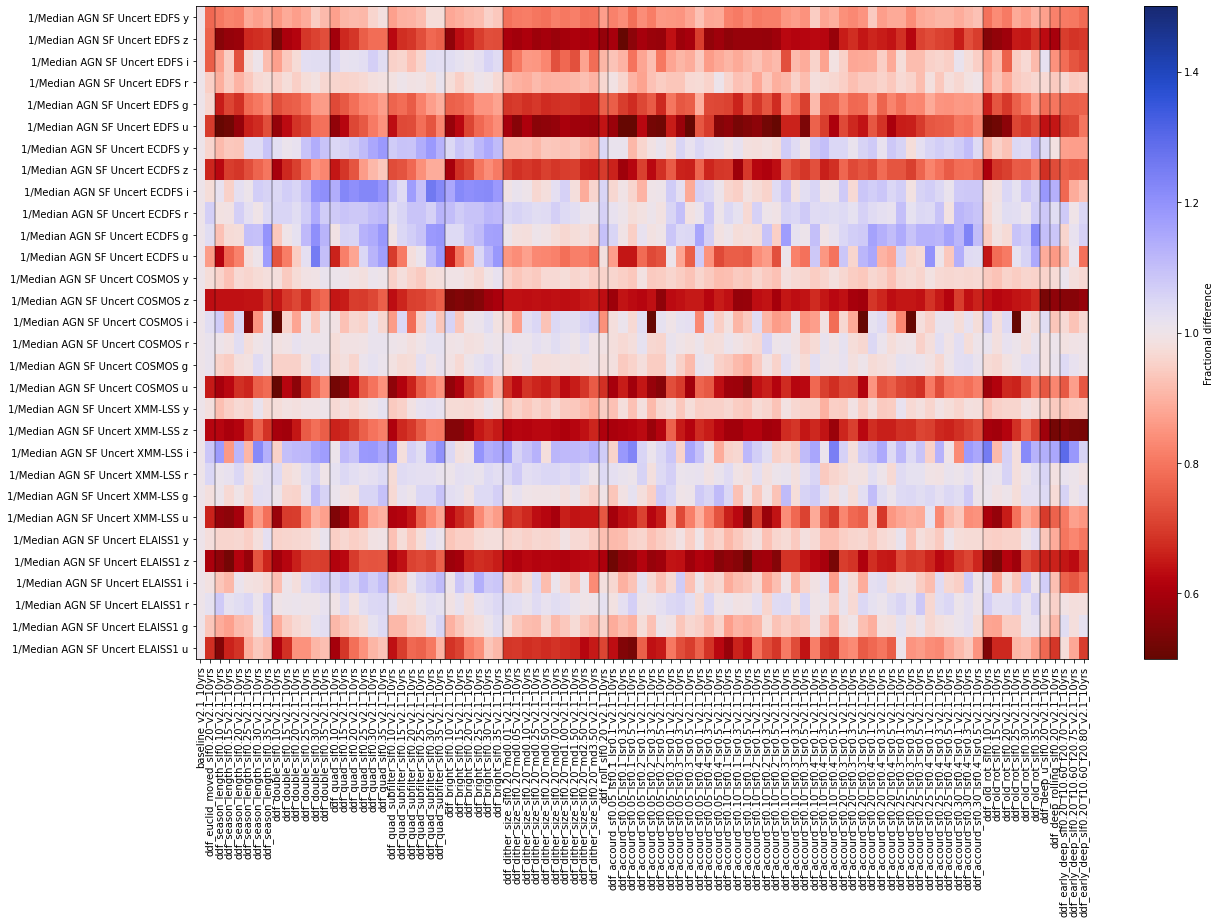

In [51]:
fams = [f for f in family_list if f.startswith('ddf') and f!='ddf percent']
k = 'AGN SF DDF'
metrics = mset.loc[k]

#baseline = families.loc[fams]['reference'][0]
baseline = 'baseline_v2.1_10yrs'
these_runs = np.concatenate([[baseline], families.explode(['run']).loc[fams]['run']])

fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metrics['metric']],
                                  baseline_run=baseline,
                                  metric_label_map=metrics['short_name'],
                                  metric_set=metrics, 
                                  color_range=1)
fig.set_figwidth(20)
fig.set_figheight(12)
for l in (plot_lines(families, fams)+1):
    ax.axvline(l, color='k', alpha=0.3)
    

One thing that jumps out is that the results all differ from the baseline_v2.1 metric values. `baseline_v2.1_10yrs` did NOT use pre-scheduled DDFs, and that seems to make quite a bit of different particularly in z and u bands (which, notably, are the filters we swap over the lunar cycle, and the pre-scheduling was intended to make best advantage of the deeper visits around new moon and avoid bright time). 

To make it easier to see the effects of the different pre-scheduled strategies, we'll swap the baseline to one of these pre-scheduled versions (`ddf_season_length_slf0.20_v2.1_10yrs` uses an intermediate-length season but no other advantages of pre-scheduling). 

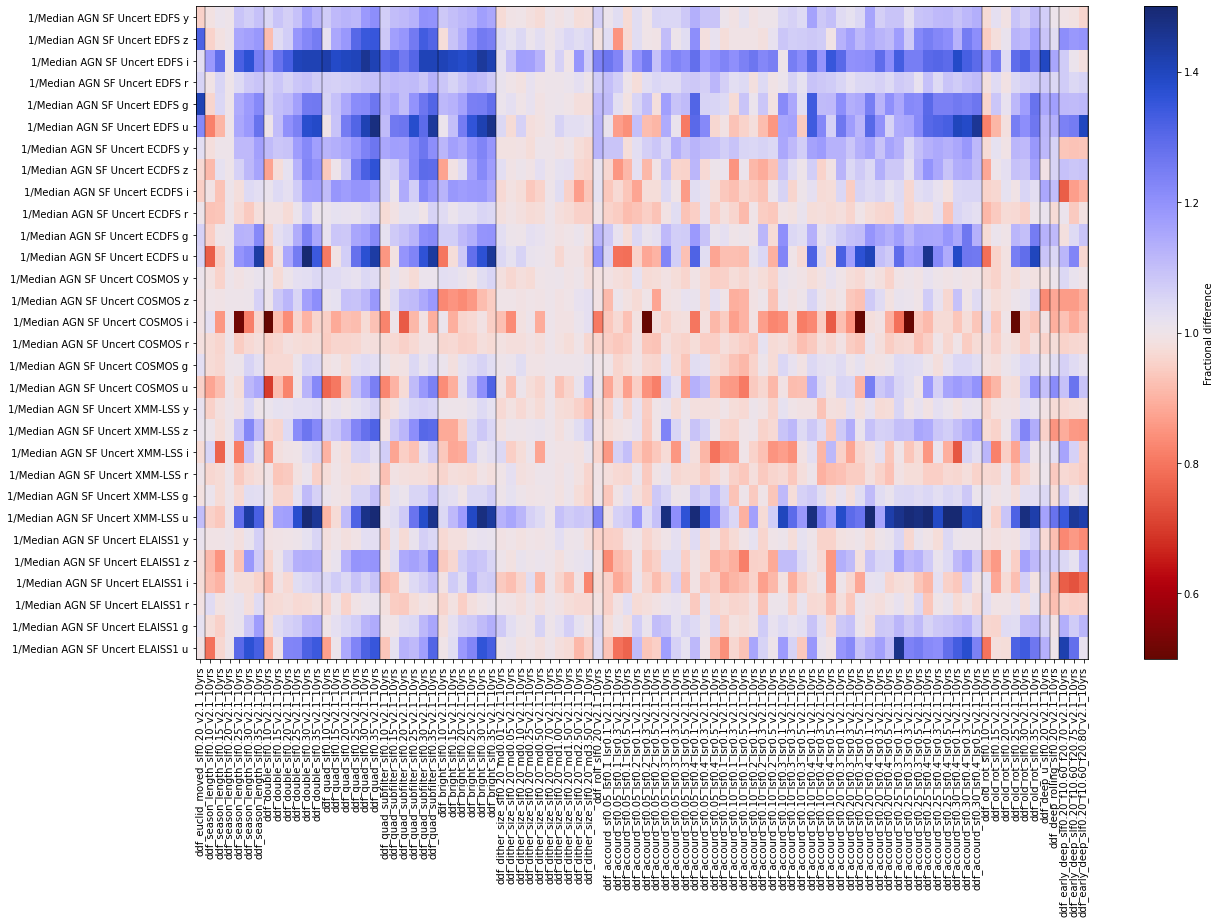

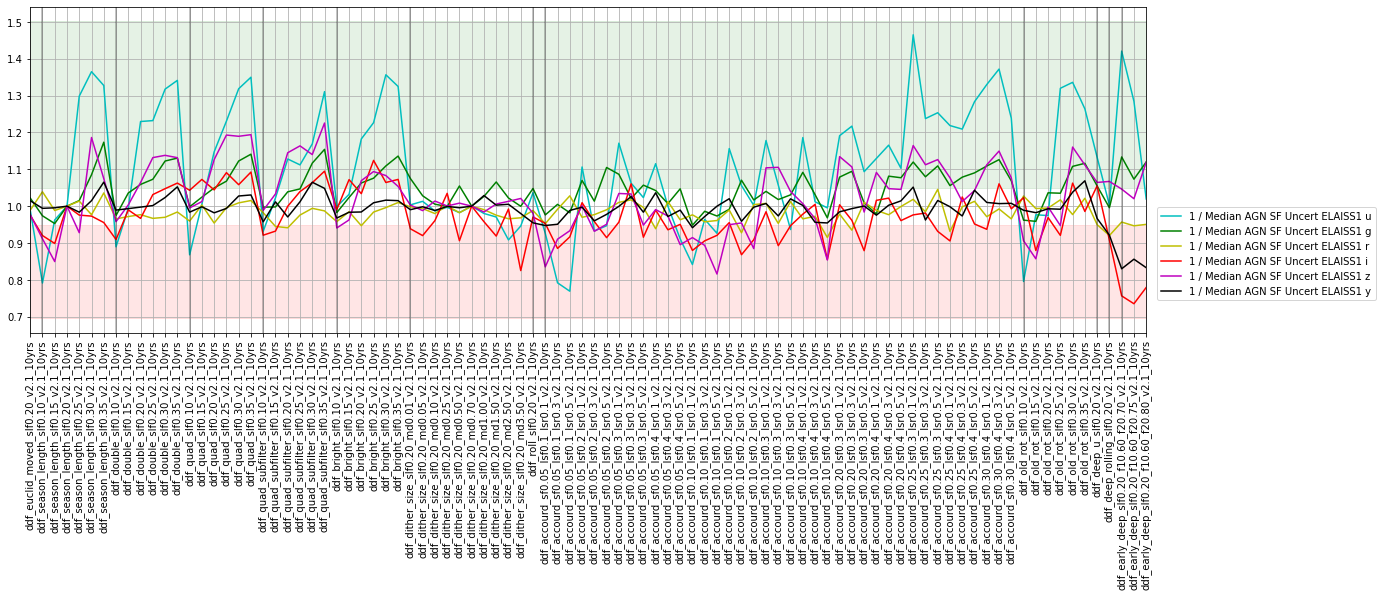

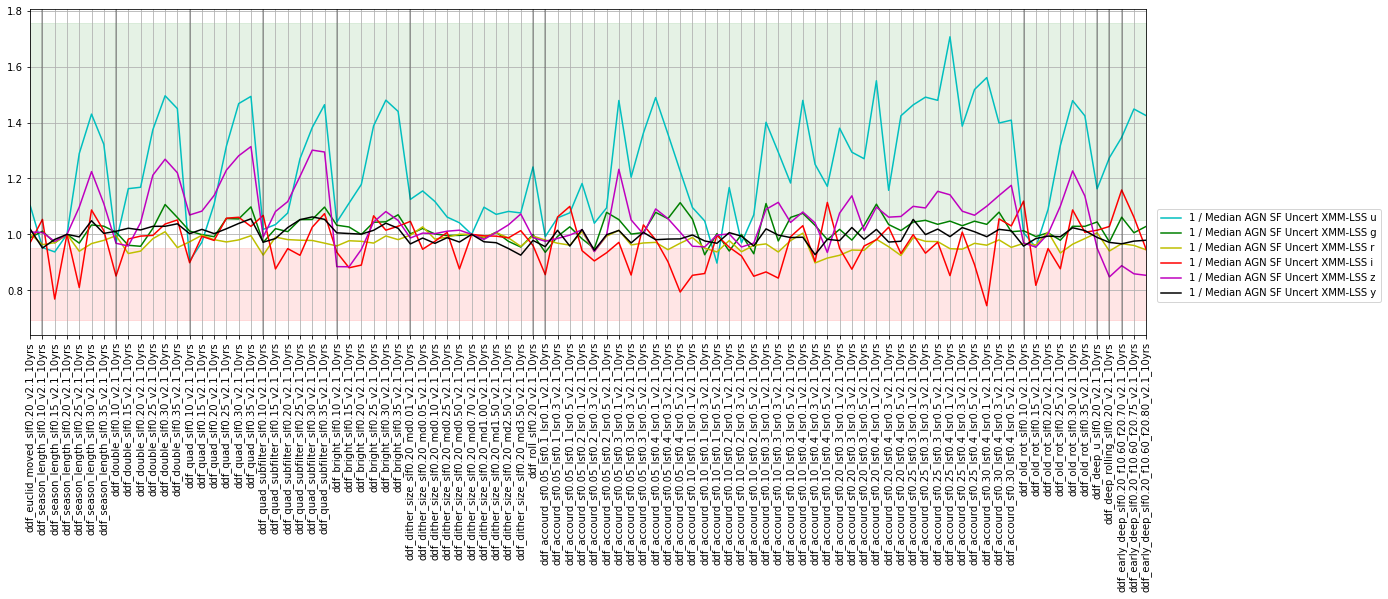

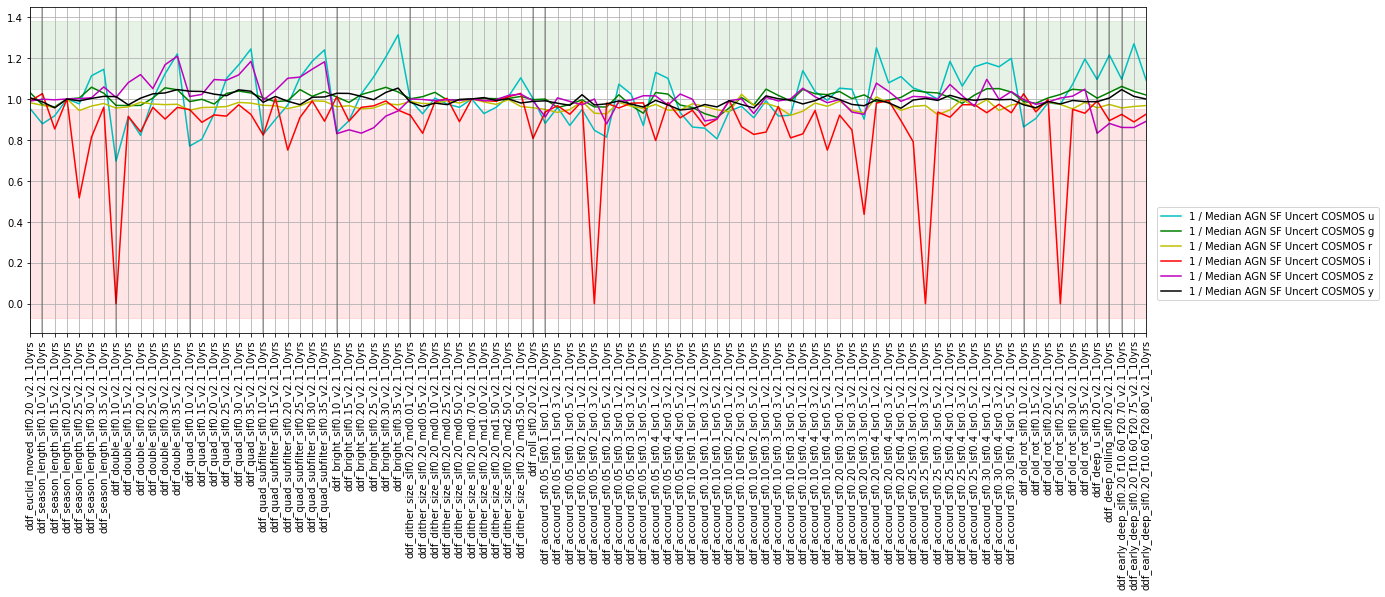

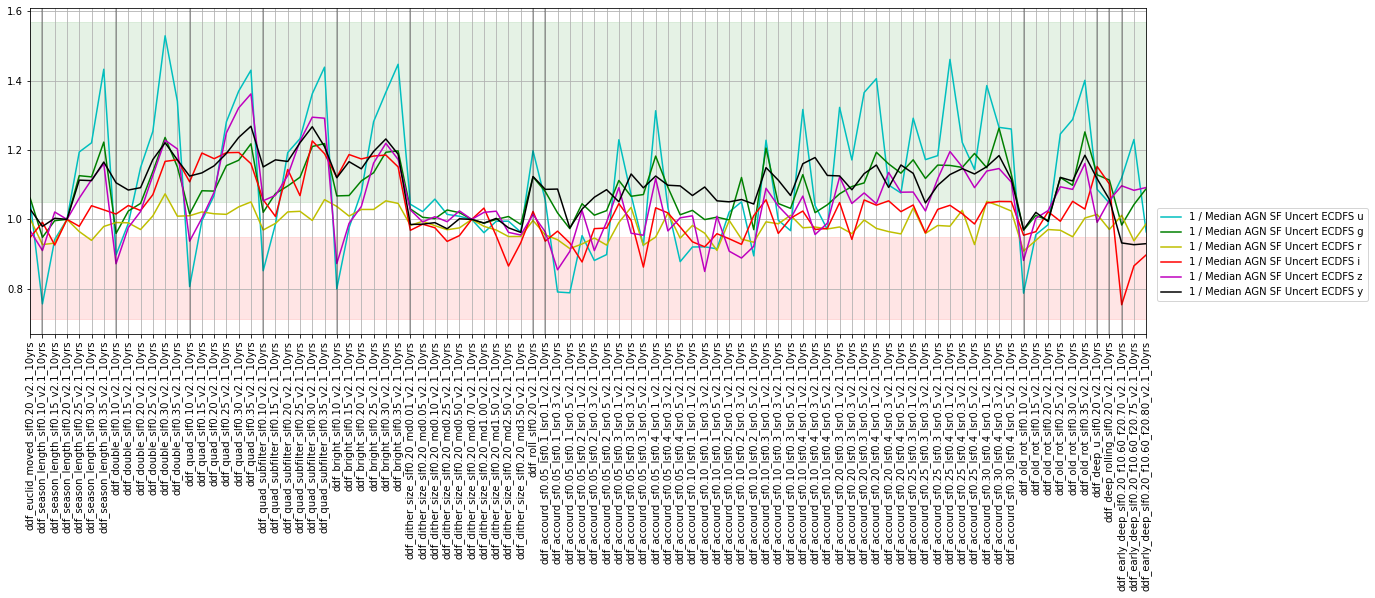

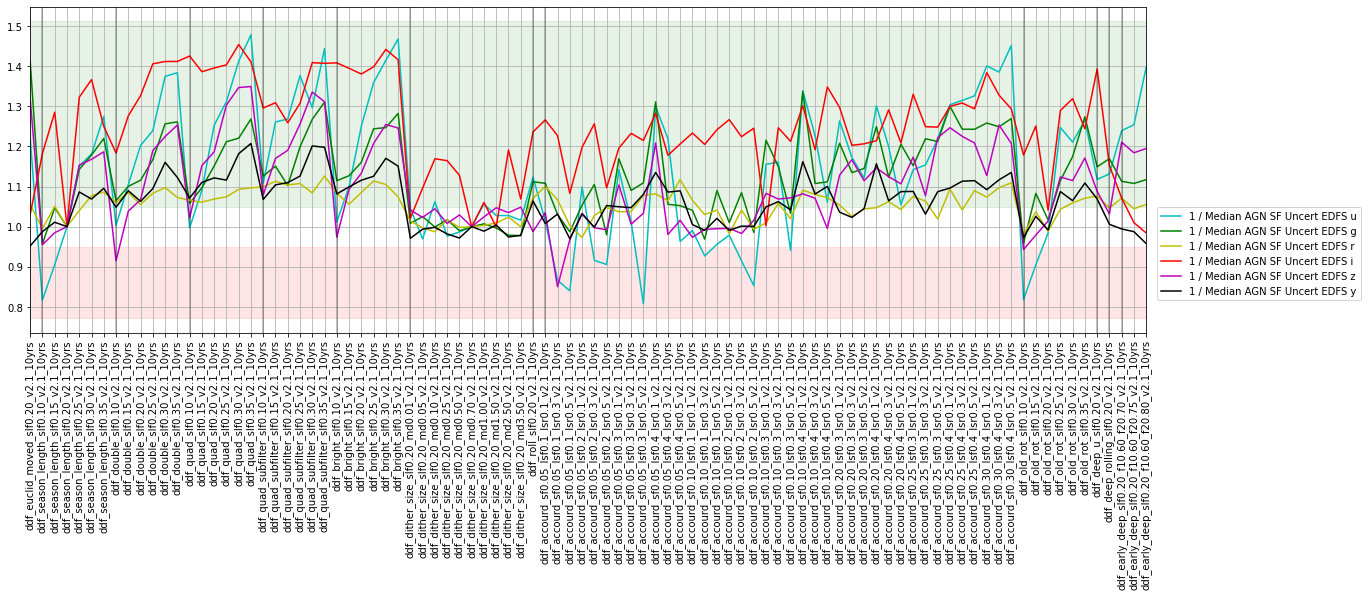

In [53]:
fams = [f for f in family_list if f.startswith('ddf') and f!='ddf percent']
k = 'AGN SF DDF'
metrics = mset.loc[k]

baseline = 'ddf_season_length_slf0.20_v2.1_10yrs'
these_runs = families.explode(['run']).loc[fams]['run']

fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metrics['metric']],
                                  baseline_run=baseline,
                                  metric_label_map=metrics['short_name'],
                                  metric_set=metrics, 
                                  color_range=1)
fig.set_figwidth(20)
fig.set_figheight(12)
for l in (plot_lines(families, fams)):
    ax.axvline(l, color='k', alpha=0.3)
    
for dd in ddfs:
    msubset = mset.loc[k].query('metric.str.contains(@dd)')
    fig, ax = maf.plot_run_metric(summaries.loc[these_runs, msubset['metric']],
                                      baseline_run=baseline,
                                      metric_label_map=msubset['short_name'],
                                      metric_set=msubset,
                                 horizontal_quantity='run',
                                 vertical_quantity='value')
    fig.set_figwidth(20)
    #ax.set_ylim(0.5, 1.15)
    ax.legend(loc=(1.01, 0.1))
    for l in (plot_lines(families, fams)):
        ax.axvline(l, color='k', alpha=0.3)

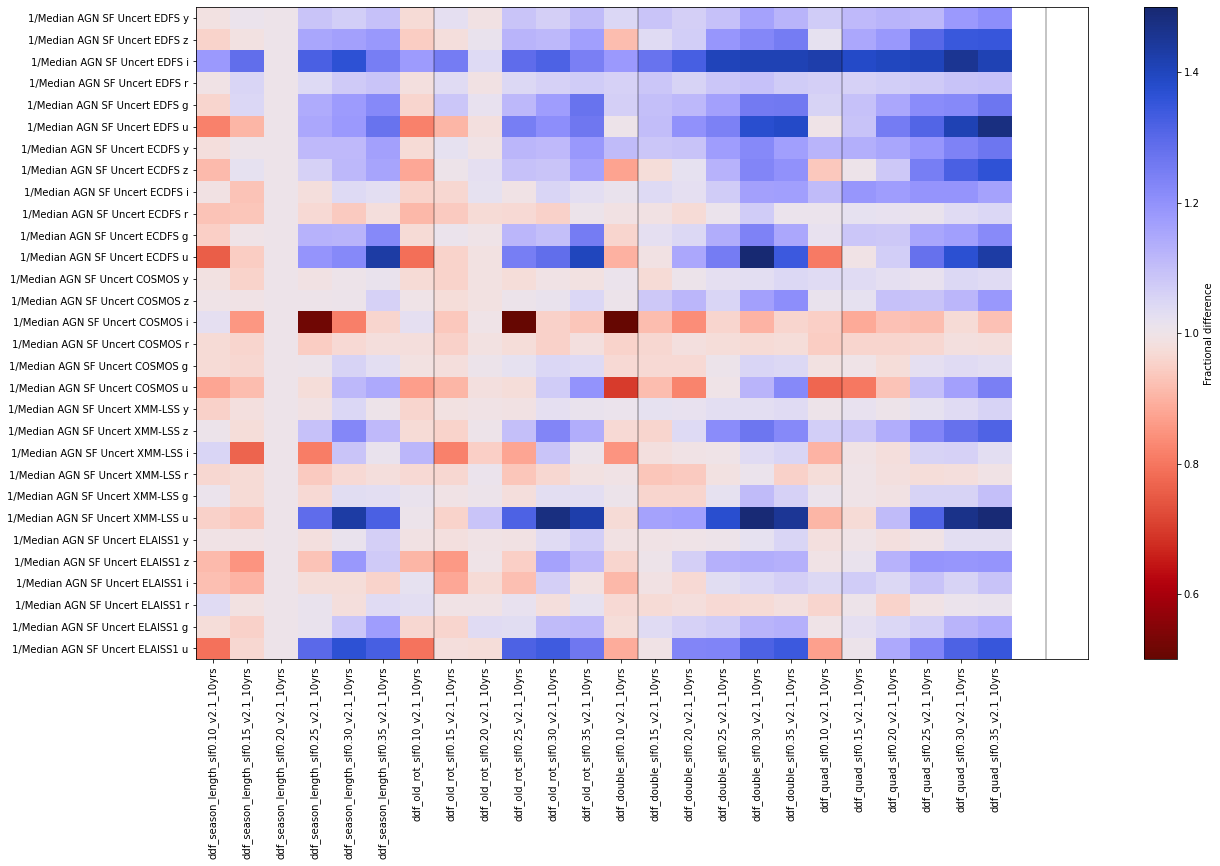

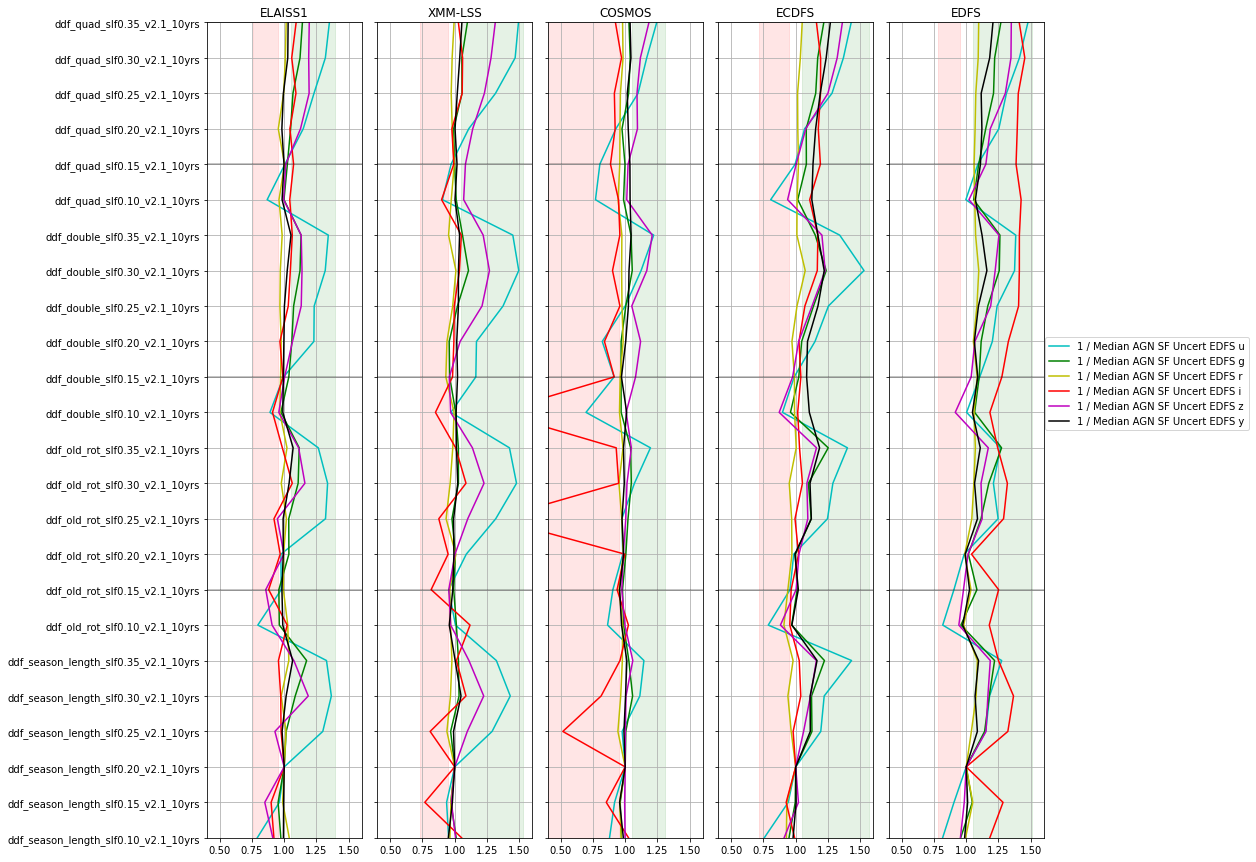

In [54]:
fams = ['ddf season length', 'ddf old rot', 'ddf double', 'ddf quad',]
#baseline = families.loc[fams]['reference'][0]
baseline = 'ddf_season_length_slf0.20_v2.1_10yrs'
these_runs = np.concatenate([[], families.explode(['run']).loc[fams]['run']])

fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metrics['metric']],
                                  baseline_run=baseline,
                                  metric_label_map=metrics['short_name'],
                                  metric_set=metrics, 
                                  color_range=1)
fig.set_figwidth(20)
fig.set_figheight(12)
for l in (plot_lines(families, fams)+1):
    ax.axvline(l, color='k', alpha=0.3)


fig = plt.figure(figsize=(15, 15))
gs = fig.add_gridspec(ncols=5, nrows=1, wspace=0.1)
axs = gs.subplots(sharey=True)
for dd, ax  in zip(ddfs, axs):
    msubset = mset.loc[k].query('metric.str.contains(@dd)')
    fig, ax = maf.plot_run_metric(summaries.loc[these_runs, msubset['metric']],
                                      baseline_run=baseline,
                                      metric_label_map=msubset['short_name'],
                                      metric_set=msubset,
                                 horizontal_quantity='value',
                                 vertical_quantity='run',
                                 ax=ax)
    ax.get_legend().remove()
    ax.set_xlim(0.4, 1.6)
    ax.set_title(dd)
    for l in (plot_lines(families, fams)+1):
        ax.axhline(l, color='k', alpha=0.3)
ax.legend(loc=(1.01, 0.5))

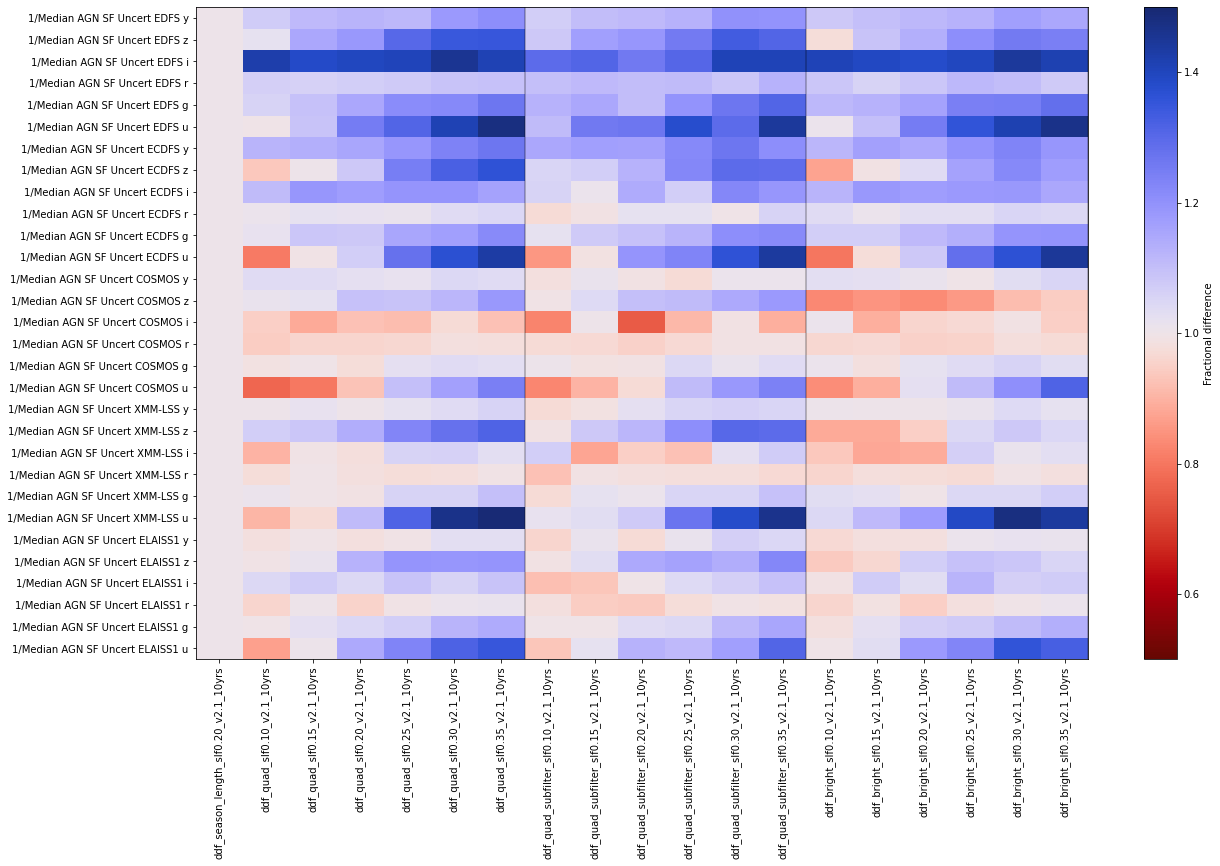

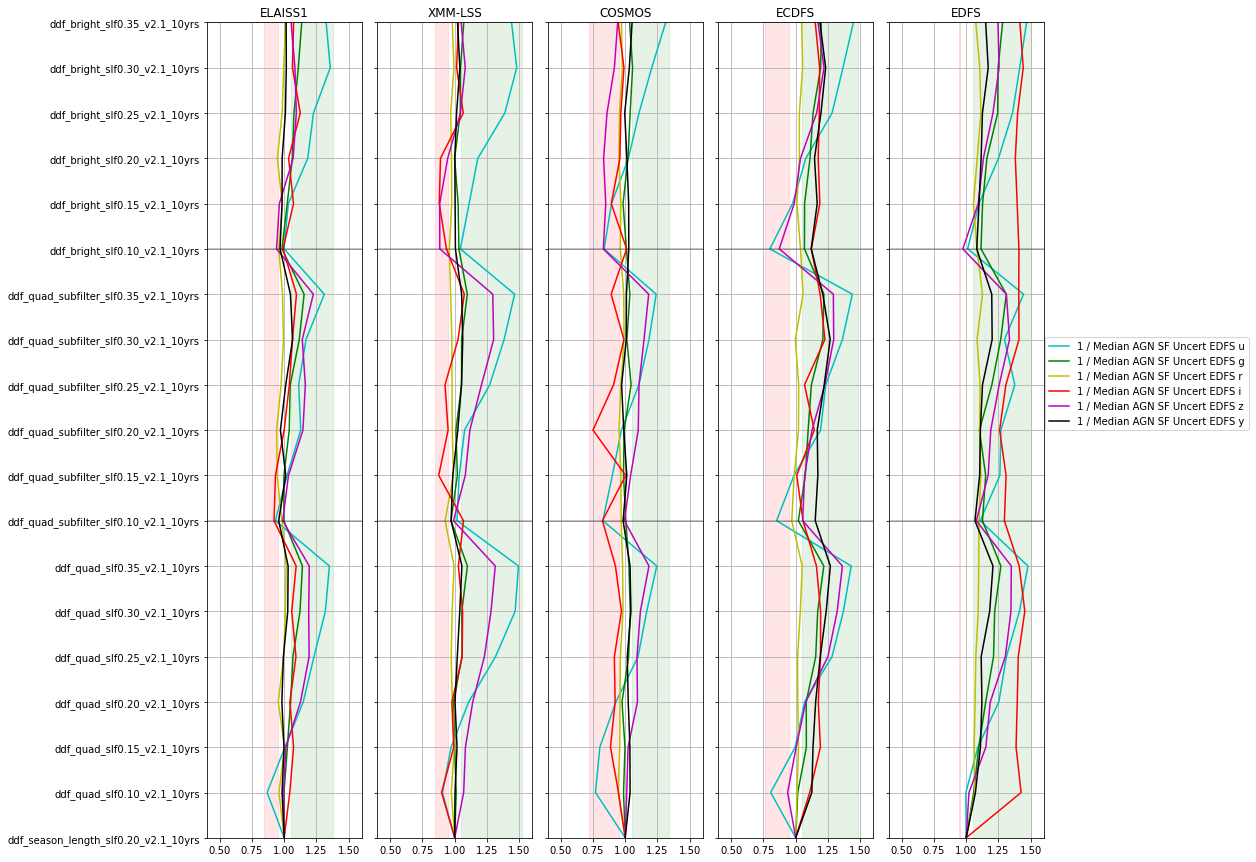

In [56]:
fams = ['ddf quad', 'ddf quad subfilter', 'ddf bright']
baseline = 'ddf_season_length_slf0.20_v2.1_10yrs'
these_runs = np.concatenate([[baseline], families.explode(['run']).loc[fams]['run']])

fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metrics['metric']],
                                  baseline_run=baseline,
                                  metric_label_map=metrics['short_name'],
                                  metric_set=metrics, 
                                  color_range=1)
fig.set_figwidth(20)
fig.set_figheight(12)
for l in (plot_lines(families, fams)+1):
    ax.axvline(l, color='k', alpha=0.3)


fig = plt.figure(figsize=(15, 15))
gs = fig.add_gridspec(ncols=5, nrows=1, wspace=0.1)
axs = gs.subplots(sharey=True)
for dd, ax  in zip(ddfs, axs):
    msubset = mset.loc[k].query('metric.str.contains(@dd)')
    fig, ax = maf.plot_run_metric(summaries.loc[these_runs, msubset['metric']],
                                      baseline_run=baseline,
                                      metric_label_map=msubset['short_name'],
                                      metric_set=msubset,
                                 horizontal_quantity='value',
                                 vertical_quantity='run',
                                 ax=ax)
    ax.get_legend().remove()
    ax.set_xlim(0.4, 1.6)
    ax.set_title(dd)
    for l in (plot_lines(families, fams)+1):
        ax.axhline(l, color='k', alpha=0.3)
ax.legend(loc=(1.01, 0.5))

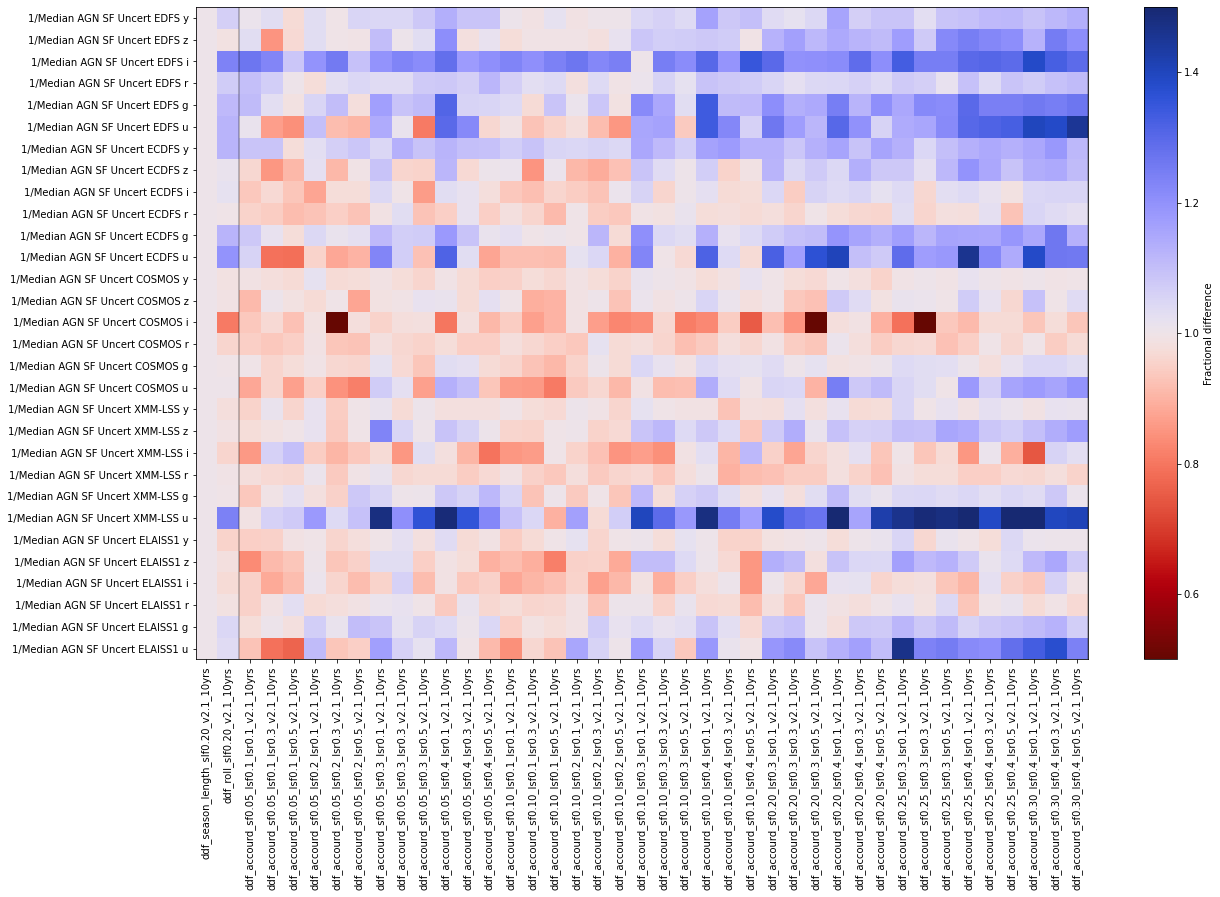

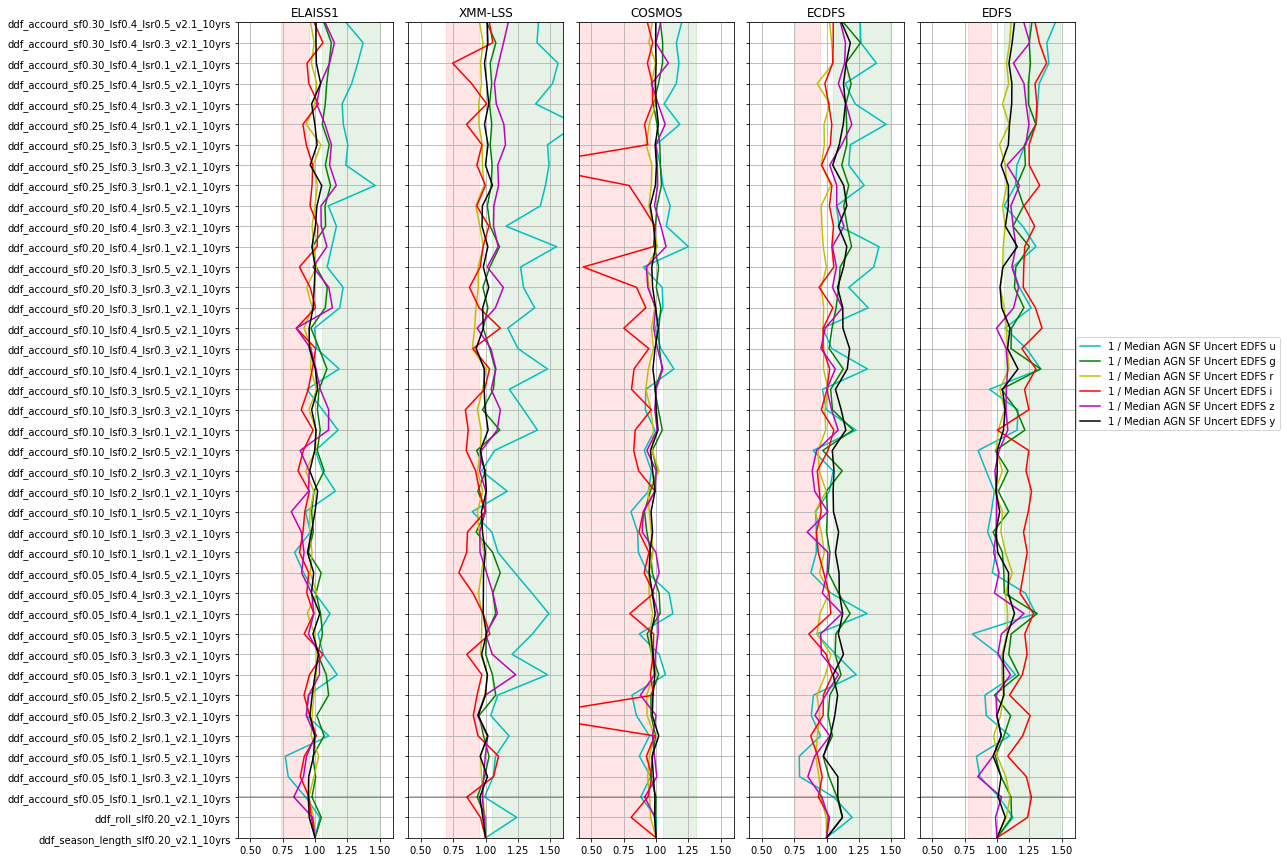

In [57]:
fams = ['ddf roll', 'ddf accordian']
baseline = 'ddf_season_length_slf0.20_v2.1_10yrs'
these_runs = np.concatenate([[baseline], families.explode(['run']).loc[fams]['run']])

fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metrics['metric']],
                                  baseline_run=baseline,
                                  metric_label_map=metrics['short_name'],
                                  metric_set=metrics, 
                                  color_range=1)
fig.set_figwidth(20)
fig.set_figheight(12)
for l in (plot_lines(families, fams)+1):
    ax.axvline(l, color='k', alpha=0.3)


fig = plt.figure(figsize=(15, 15))
gs = fig.add_gridspec(ncols=5, nrows=1, wspace=0.1)
axs = gs.subplots(sharey=True)
for dd, ax  in zip(ddfs, axs):
    msubset = mset.loc[k].query('metric.str.contains(@dd)')
    fig, ax = maf.plot_run_metric(summaries.loc[these_runs, msubset['metric']],
                                      baseline_run=baseline,
                                      metric_label_map=msubset['short_name'],
                                      metric_set=msubset,
                                 horizontal_quantity='value',
                                 vertical_quantity='run',
                                 ax=ax)
    ax.get_legend().remove()
    ax.set_xlim(0.4, 1.6)
    ax.set_title(dd)
    for l in (plot_lines(families, fams)+1):
        ax.axhline(l, color='k', alpha=0.3)
ax.legend(loc=(1.01, 0.5))

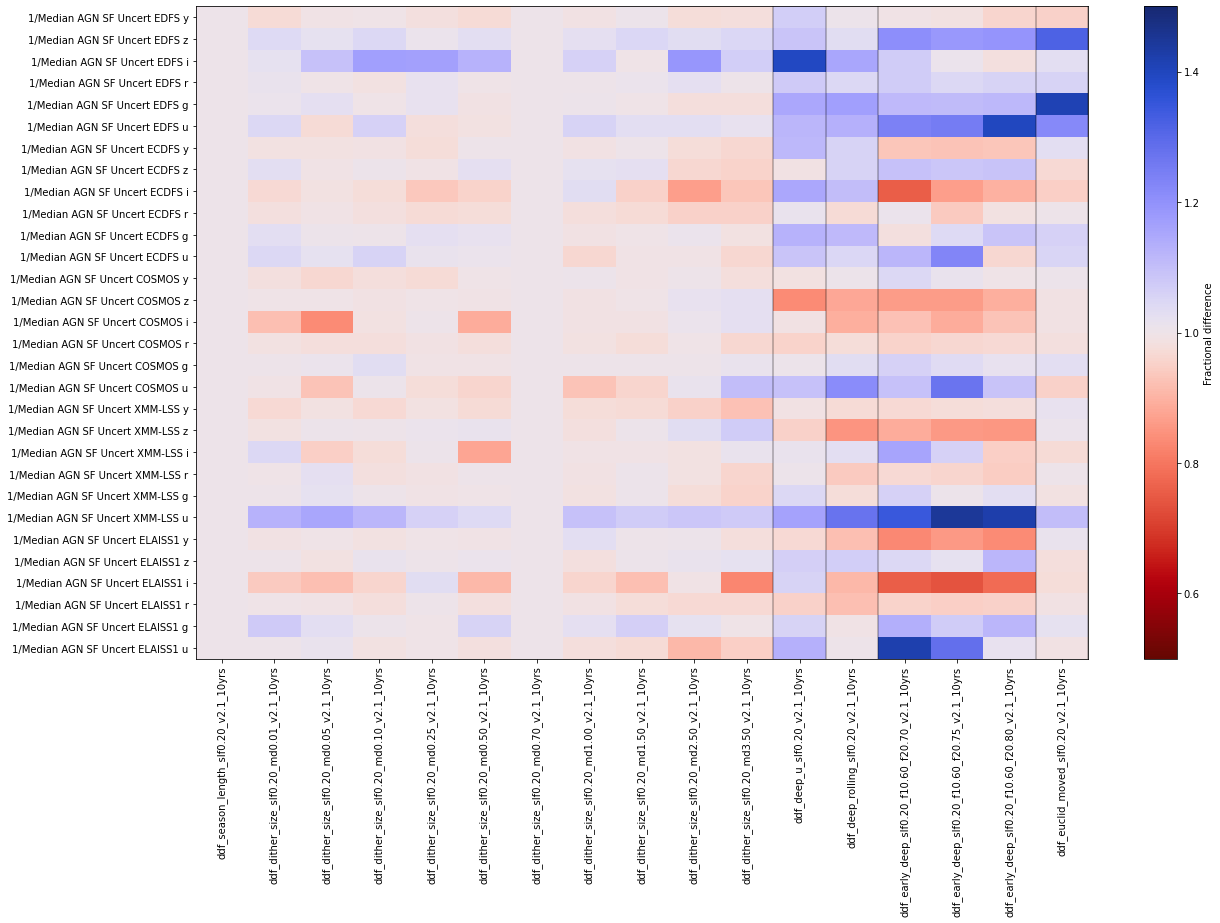

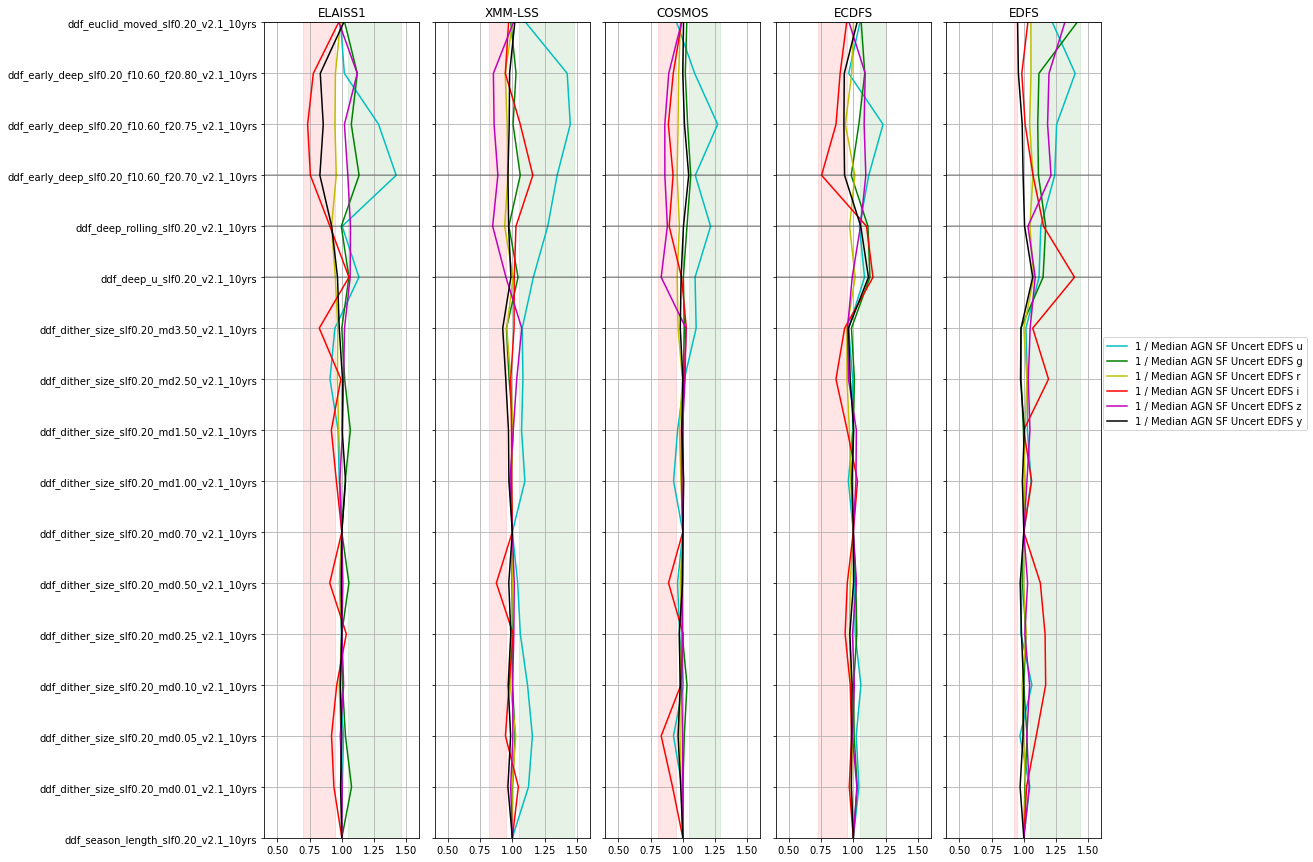

In [58]:
fams = ['ddf dither', 'ddf deep universal', 'ddf deep rolling', 'ddf early deep', 'ddf euclid moved']
baseline = 'ddf_season_length_slf0.20_v2.1_10yrs'
these_runs = np.concatenate([[baseline], families.explode(['run']).loc[fams]['run']])

fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metrics['metric']],
                                  baseline_run=baseline,
                                  metric_label_map=metrics['short_name'],
                                  metric_set=metrics, 
                                  color_range=1)
fig.set_figwidth(20)
fig.set_figheight(12)
for l in (plot_lines(families, fams)+1):
    ax.axvline(l, color='k', alpha=0.3)


fig = plt.figure(figsize=(15, 15))
gs = fig.add_gridspec(ncols=5, nrows=1, wspace=0.1)
axs = gs.subplots(sharey=True)
for dd, ax  in zip(ddfs, axs):
    msubset = mset.loc[k].query('metric.str.contains(@dd)')
    fig, ax = maf.plot_run_metric(summaries.loc[these_runs, msubset['metric']],
                                      baseline_run=baseline,
                                      metric_label_map=msubset['short_name'],
                                      metric_set=msubset,
                                 horizontal_quantity='value',
                                 vertical_quantity='run',
                                 ax=ax)
    ax.get_legend().remove()
    ax.set_xlim(0.4, 1.6)
    ax.set_title(dd)
    for l in (plot_lines(families, fams)+1):
        ax.axhline(l, color='k', alpha=0.3)
ax.legend(loc=(1.01, 0.5))